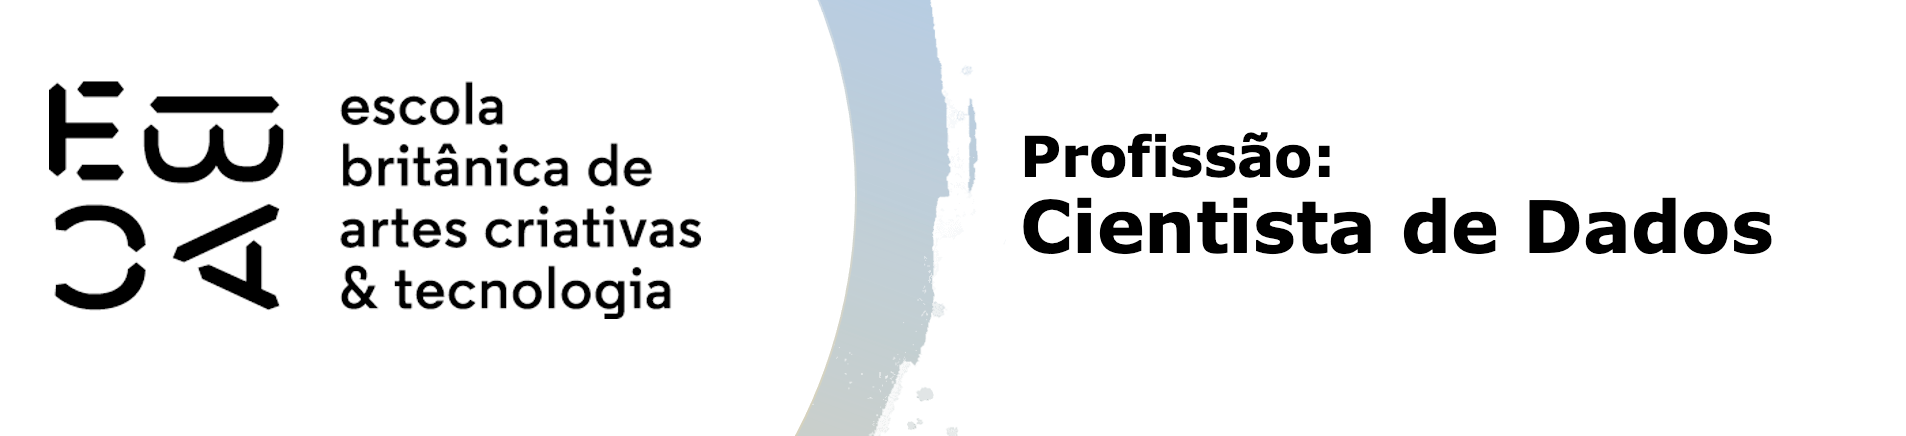

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import unidecode

import statsmodels.formula.api as smf
import statsmodels.api as sm

import pyarrow
from pycaret.classification import *
from pycaret.datasets import get_data

from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from scipy.stats import ks_2samp, t, uniform, randint

from xgboost import XGBClassifier

In [2]:
df = pd.read_feather(r'\Users\Meu Computador\anaconda3\EBAC\M 37 - Regressão Logística II\credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
df_3_meses = (
    df[df['data_ref'].dt.to_period('M')     # converte para períodos mensais
    .isin(df['data_ref'].dt.to_period('M')  # cria uma máscara booleana, indicando quais linhas pertencem aos 3 meses
    .unique()[-3:])]                        # pega os últimos 3 meses
)

print(f'O conjunto de dados possue {df_3_meses.shape[0]} linhas e {df_3_meses.shape[1]} colunas.')
df_3_meses.head()

O conjunto de dados possue 150000 linhas e 15 colunas.


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False


In [4]:
metadados = pd.DataFrame(df_3_meses.dtypes, columns=['dtypes'])
metadados = metadados.drop(index=['data_ref', 'index'])
metadados['nmissing'] = df_3_meses.isna().sum()
metadados['valores_unicos'] = df_3_meses.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'

metadados

,dtypes,nmissing,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,25082,3004,covariavel


In [5]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [6]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_3_meses[var],5,duplicates='drop'), df_3_meses.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_3_meses[var], df_3_meses.mau)

metadados.sort_values(by='IV', ascending=False)

,dtypes,nmissing,valores_unicos,papel,IV
renda,float64,0,46077,covariavel,0.744982
tempo_emprego,float64,25082,3004,covariavel,0.367182
idade,int64,0,47,covariavel,0.019268
posse_de_imovel,object,0,2,covariavel,0.010444
tipo_renda,object,0,5,covariavel,0.009772
educacao,object,0,5,covariavel,0.003984
tipo_residencia,object,0,6,covariavel,0.003348
sexo,object,0,2,covariavel,0.001712
qt_pessoas_residencia,float64,0,9,covariavel,0.001711
estado_civil,object,0,5,covariavel,0.000955


### IV - Information Value

Essa métrica mede quanto poder de separação uma variável tem entre duas classes.

|Faixa|Poder preditivo|
|:-|:-|
|0 a 0,02| Inútil |
|0,02 a 0,1| Fraco |
|0,1 a 0,3| Médio |
|0,3 a 0,5| Forte |
|0,5 ou mais| Suspeito de tão alto |

Com base nisso, podemos concluir que, inicialmente, as variáveis ```renda``` é suspeito por ter um IV muito alto,```tempo_emprego``` um poder preditivo forte e ```idade``` uma predição fraca.

Porém, farei uma análise mais detalhada a seguir.

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
# Número de linhas e colunas do dataset
print(f'O conjunto de dados possue:\nLinhas:{df_3_meses.shape[0]}\nColunas:{df_3_meses.shape[1]}')

# Número de linhas para cada mês
print('\n\nQuantidade de linhas para cada mês corresponde a:')
linhas_mes = df_3_meses.groupby(df_3_meses['data_ref'].dt.to_period('M')).size()
linhas_mes

O conjunto de dados possue:
Linhas:150000
Colunas:15


Quantidade de linhas para cada mês corresponde a:


data_ref
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, dtype: int64

In [8]:
# Separando as variáveis em qualitativas e quantitativas

# Dropando a coluna index, pois não nos interessa.
quantitativas = (df_3_meses.select_dtypes(include='number')
                .drop(columns='index'))

# Dropando a coluna data_ref, pois não nos interessa.
qualitativas = (df_3_meses.select_dtypes(exclude='number')
                .drop(columns='data_ref'))

# Descritiva básica

## Variáveis Quantitativas

- ```Contagem``` (count)
- ```Média``` (mean)
- ```Desvio padrão``` (std) - *dispersão dos dados*
- ```Mínimo``` (min)
- ```Quartis``` (25%, 50%, 75%)
- ```Máximo``` (max)

A seguir vou avaliar cada variável:

### qtd_filhos
```Média``` de 0.43 filho por pessoa, com ```std``` de 0.73, com ```quartis 50%``` de 0. Isso indica que a maioria das pessoas não tem filhos, mas há casos isolados com até 14 filhos (apontados no ```max```).

### idade
A idade ```média``` ficou em 43, com ```std``` de 11.2. Diferentemente da variável anterior, esta mostra uma maior dispersão nos dados, ou seja, uma heterogeneidade. Além disso, analisando o ```min``` e ```max```, constatamos que a base é composta majoritariamente por adultos em idade economicamente ativa.

### tempo_emprego
A ```média``` está em 7.7 anos com ```std``` de 6, indicando uma variação acentuada. Isto, provavelmente, se deve a discrepância do ```min``` em 0.1 e ```max``` em quase 43 anos.

### qt_pessoas_residencia
Com ```média``` de 2.2 pessoas por residência e ```std``` em 0.9 fica evidente uma homogeneidade nos dados (tal como em *qtd_filhos*). O ```max``` marca 15, indicando possíveis *outliers*.

### renda
Renda ```média``` de 7.300 reais, mas traz uma dispersão **extremamente alta** (```std``` em 20778). O ```quartis 50%``` é de apenas 2.950 reais, o que mostra *assimetria à direita*, ou seja, poucas pessoas têm rendas muito altas, beirando 732 mil.

In [9]:
quantitativas.describe().T

,count,mean,std,min,25%,50%,75%,max
qtd_filhos,150000.0,0.433413,0.737417,0.000000,0.000000,0.000000,1.000000,14.000000
idade,150000.0,43.829547,11.226707,22.000000,34.000000,43.000000,53.000000,68.000000
tempo_emprego,124918.0,7.750898,6.682998,0.117808,3.071233,6.038356,10.183562,42.906849
qt_pessoas_residencia,150000.0,2.212720,0.902114,1.000000,2.000000,2.000000,3.000000,15.000000
renda,150000.0,7301.344809,20778.675831,107.670000,1598.627500,2952.380000,5858.200000,732561.260000


## Variáveis Qualitativas

- ```Count```: quantidade de linhas
- ```Unique```: quantos valores diferentes existem na coluna
- ```Top```: valor que mais aparece
- ```Freq```: quantas vezes o valor ```top``` aparece

### sexo
A base é composta predominantemente por mulheres, o **F** aparece 100775 vezes.

### posse_de_veiculo
Cerca de *61%* **não possuem** veículos próprios. Isso demonstra um perfil financeiro mais modesto.

### posse_de_imovel
Aproximadamente *67%* possuem imóvel próprio, o que sugere uma boa estabilidade patrimonial.

### tipo_renda
Temos a classe ```Assalariado``` como ```top``` e aparecendo 77280 vezes, pouco mais de 50% das vezes.

### educacao
Predominância da classe ```Médio```, indicando escolaridade intermediária.

### estado_civil
Cerca de 70% são ```casados```, podemos deduzir que este é um público maduro e estável.

### tipo_residencia
A grande maioria, cerca de *90%*, mora em ```Casa```. Demonstra baixa concentração em apartamentos ou residências financiadas.

### mau
Aproximadamente 85% dos clientes são **bons pagadores**, visto que o ```top``` False aparece predominantemente. Para além das interpretações estatísticas, desconfio que este valor indica um dataset **desbalanceado**.

In [10]:
qualitativas.describe().T

,count,unique,top,freq
sexo,150000,2,F,100775
posse_de_veiculo,150000,2,N,91661
posse_de_imovel,150000,2,S,100638
tipo_renda,150000,5,Assalariado,77280
educacao,150000,5,Médio,101387
estado_civil,150000,5,Casado,105323
tipo_residencia,150000,6,Casa,134958
mau,150000,2,False,128000


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

### Categóricas

Para entender quais grupos têm maior risco, fiz o cálculo da taxa de inadimplência média (```mean```) e o total de registros (```count```) para cada categoria.

In [11]:
# Lista das variáveis categóricas
variaveis_cat = [
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia'
]

resultados = []   # Cria uma lista vazia

for var in variaveis_cat:  # O loop vai repetir para as variáveis que estão na lista das categóricas
    temp = (
        df_3_meses.groupby(var)['mau']  # Agrupa o DF pela variável que está na lista
        .agg(taxa_inadimplencia='mean', total='count')  # Aplica as operações: média e contagem total
        .reset_index()   # Transforma o índice do groupby em coluna normal
    )
    temp['variavel'] = var   # Cria uma nova coluna com o nome da variavel que está em loop
    temp.rename(columns={var: 'categoria'}, inplace=True) # Renomeia a coluna que antes tinha o nome da variável para categoria
    resultados.append(temp) # Adiciona o DF temp à lista resultado

df_bivariada = pd.concat(resultados, ignore_index=True) # Concatena todos os dataframes em um único.
df_bivariada = df_bivariada[['variavel', 'categoria', 'taxa_inadimplencia', 'total']] # Mantém as colunas nesta ordem

# Ordena o DataFrame por variável e taxa de inadimplência (decrescente)
df_bivariada = df_bivariada.sort_values(by=['variavel', 'taxa_inadimplencia'], ascending=[True, False])

# Cria o ranking dentro de cada variável
df_bivariada['ranking_risco'] = (
    df_bivariada.groupby('variavel')['taxa_inadimplencia']
    .rank(method='first', ascending=False)
    .astype(int)
)

# Reorganiza as colunas
df_bivariada = df_bivariada[['variavel', 'categoria', 'taxa_inadimplencia', 'total', 'ranking_risco']]

df_bivariada

,variavel,categoria,taxa_inadimplencia,total,ranking_risco
11,educacao,Fundamental,0.182198,1674,1
15,educacao,Superior incompleto,0.156123,5912,2
12,educacao,Médio,0.150118,101387,3
14,educacao,Superior completo,0.135467,40866,4
13,educacao,Pós graduação,0.099379,161,5
19,estado_civil,União,0.153667,11577,1
17,estado_civil,Separado,0.153525,8383,2
18,estado_civil,Solteiro,0.152348,18438,3
16,estado_civil,Casado,0.144793,105323,4
20,estado_civil,Viúvo,0.139353,6279,5


## Insights

### educacao
Temos uma tendência inversa entre escolaridade e inadimplência: quanto menor a escolaridade, maior a taxa de inadimplência. Isso fica evidente quando analisamos a tabela e percebemos que ```fundamental``` possui 18% e ```pós graduação``` 9.9%, indicando que a educação formal pode estar associada a melhor planejamento financeiro e estabilidade.

### estado_civil
As categorias estão balanceadas, a *taxa* tem pouca amplitude, porém, destaco que as categorias ```casado``` e ```viúvos``` trazem maior segurança, possivelmente por maior estabilidade emocional e financeira.

### posse_de_imovel
Este é um indicador de estabilidade patrimonial e financeira, influenciando diretamente no *risco de crédito*. Quem **não possui** imóvel tem maior chance de tornar-se inadimplente.

### posse_de_veiculo
Já a ```posse_de_veiculo``` traz um cenário contrário: a diferença é tão pequena que podemos deduzir que possuir veículo não altera tanto o risco. Essa categoria não discrimina fortemente o comportamento de crédito.

### sexo
O sexo ```feminino``` traz uma pequena diferença na *taxa*, comparando-a com o ```masculino```. Apesar da diferença não ser muito significativa, pode refletir perfis de consumo distintos, por exemplo, mulheres tendem a consumir mais, automaticamente compram mais e, por sua vez, aumentam a chance de tornarem-se inadimplentes.

### tipo_renda
Os ```pensionistas``` e ```assalariados``` trazem uma taxa semelhante, 15.6% e 15%, respectivamente. De fato, estas são variáveis muito discriminantes.
Todavia, o que mais me chamou a atenção foi a relação entre as categorias ```servidor público``` e  ```bolsista```. Isto demonstra que uma renda estável e previsível tende a diminuir a inadimplência.

### tipo_residencia
As maiores taxas (```Com os pais```, ```Alguel``` e ```Comunitario```) indicam que pessoas sem moradia própria não possuem estabilidade financeira e, consequentemente, aumentam a probabilidade de tornarem-se inadimplentes; talvez por renda instável ou dependência familiar.

As informações da categoria ```posse_de_imovel``` corrobora com essa ideia, visto que o *N* desta categoria detém o maior valor de inadimplência também.

---

## Conclusão

Concluo que a inadimplência parece estar mais ligada a **estabilidade financeira** e **social** do que a características individuais simples, como sexo.

As variáveis com maior poder discriminante são:
- educação
- tipo de renda
- tipo de residência
- posso de ímovel

---

## Gráfico
No gráfico abaixo, fica visualmente evidente essas conclusões.

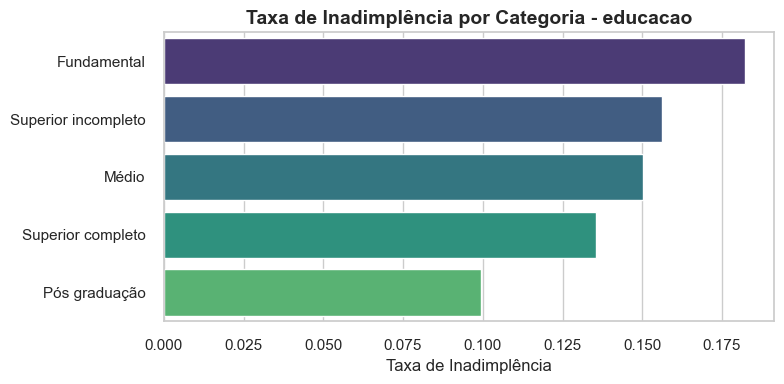

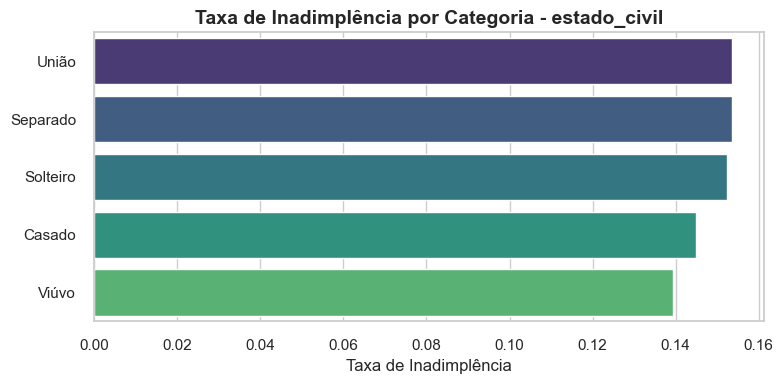

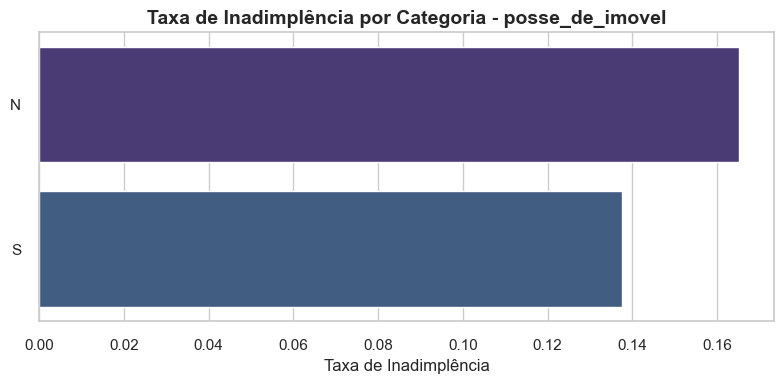

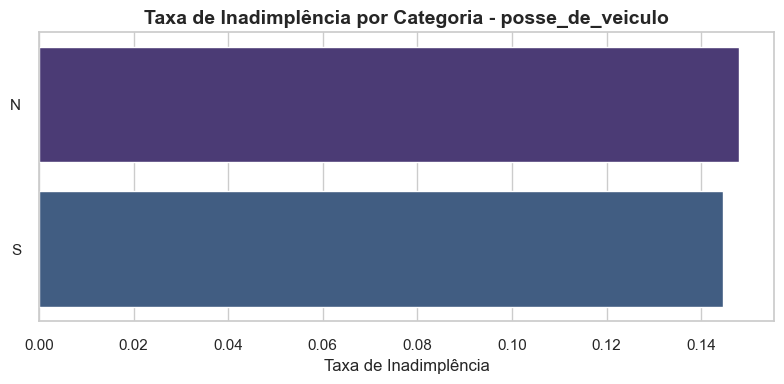

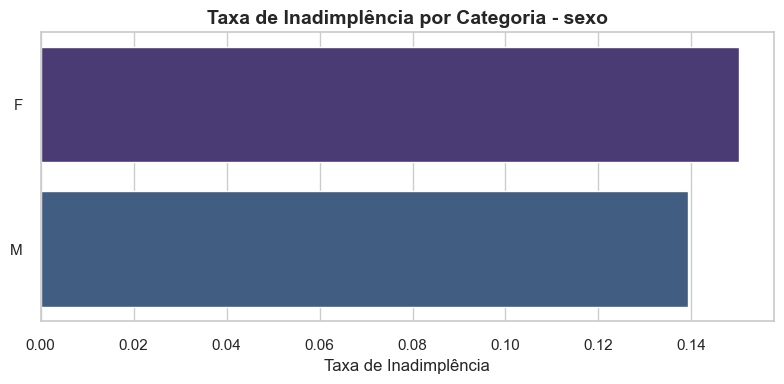

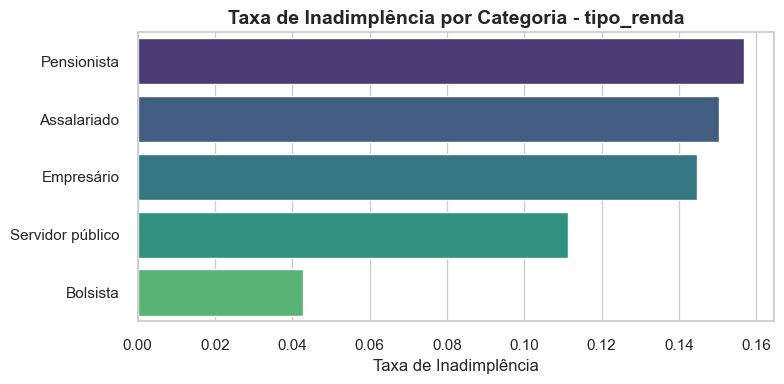

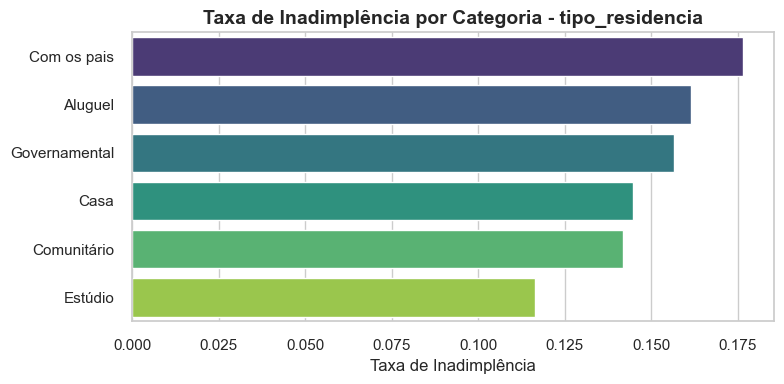

In [12]:
# Define o estilo dos gráficos
sns.set(style="whitegrid", palette="viridis")

# Lista das variáveis categóricas no mu DataFrame bivariado
variaveis = df_bivariada['variavel'].unique()

# Loop para criar um gráfico por variável
for var in variaveis:
    temp = df_bivariada[df_bivariada['variavel'] == var].sort_values('taxa_inadimplencia', ascending=False)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=temp,
        x='taxa_inadimplencia',
        y='categoria',
        hue='categoria',
        dodge=False,
        legend=False
    )
    
    plt.title(f'Taxa de Inadimplência por Categoria - {var}', fontsize=14, weight='bold')
    plt.xlabel('Taxa de Inadimplência')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [13]:
df_3_meses.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False


### Numéricas

Para identificar como o perfil númerico difere entre bons e maus pagadores, usei as métricas da ```média```, ```desvios padrão```, ```mínimos``` e ```máximos``` de cada variável, separados entre *mau=True* e *mau=False*.

In [14]:
# Lista com as variáveis numéricas
variaveis_num = [
    'qtd_filhos',
    'idade',
    'tempo_emprego',
    'qt_pessoas_residencia',
    'renda'
]

resultados_num = [] # Cria uma lista vazia

for var in variaveis_num: # O loop repitirá para as variáveis dentro do variaveis_num
    temp = (
        df_3_meses.groupby('mau')[var] # Agrupo o 'mau' com a variável do loop
        .agg(media='mean', desvio='std', minimo='min', maximo='max') # Calcula a média, std, mínimo e máximo
        .reset_index()  # Transforma o índice do groupby em coluna normal
    )
    temp['variavel'] = var        # Cria uma nova coluna com o nome da variável do loop
    resultados_num.append(temp)   # Adiciona os resultados na lista vazia

df_num = pd.concat(resultados_num, ignore_index=True)  # Concatena os DFs em um único
df_num = df_num[['variavel', 'mau', 'media', 'desvio', 'minimo', 'maximo']] # Mantém a ordem das colunas
df_num['mau'] = df_num['mau'].replace(
    {False: 'Adimplente',
     True: 'Inadimplente'}
)
df_num

,variavel,mau,media,desvio,minimo,maximo
0,qtd_filhos,Adimplente,0.430922,0.733569,0.000000,14.000000
1,qtd_filhos,Inadimplente,0.447909,0.759272,0.000000,14.000000
2,idade,Adimplente,44.007250,11.157474,22.000000,68.000000
3,idade,Inadimplente,42.795636,11.567582,22.000000,68.000000
4,tempo_emprego,Adimplente,8.250607,6.916627,0.117808,42.906849
5,tempo_emprego,Inadimplente,4.796504,3.959040,0.117808,42.906849
6,qt_pessoas_residencia,Adimplente,2.211117,0.898100,1.000000,15.000000
7,qt_pessoas_residencia,Inadimplente,2.222045,0.925084,1.000000,15.000000
8,renda,Adimplente,8151.831732,22312.816746,113.360000,732561.260000
9,renda,Inadimplente,2353.057255,4293.295987,107.670000,255733.920000


# Insights

### qtd_filhos
Não é uma variável discriminante, visto que a ```media``` e o ```desvio``` possuem valores próximos.

### idade
Pessoas mais velhas tendem a serem mais responsáveis financeiramente, corroborando com o resultado do dataframe, onde a ```media``` para inandimplentes está em 42 e adimplentes em 44.

### tempo_emprego
Indica que quanto *menor* o tempo no emprego, *maior* a chance de inadimplência. 

### qt_pessoas_residencia
Tal como a ```qtd_filhos```, esta variável não explica muito bem o perfil inadimplente. ```Media``` e ```desvio``` semelhantes trazem essa ausência de informação.

### renda
De fato, uma variável importante para esta análise de crédito. Percebe-se que quanto *maior* a renda, *menor* a inadimplência. 

Ainda, podemos fazer uma ligação com a variável ```tempo_emprego``` onde, a priori, quanto maior o tempo num emprego, maior a probabilidade de ganhar promoções e aumentar o salário, culminando num perfil financeiro estável e seguro.

Todavia, destaco que esta variável possui um ```desvio``` astronômico, indicando possíveis *outliers*.

---

## Gráfico

O gráfico abaixo evidencia visualmente os insights.

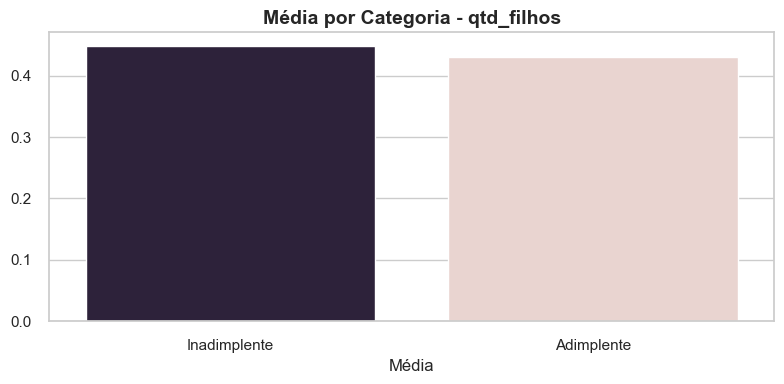

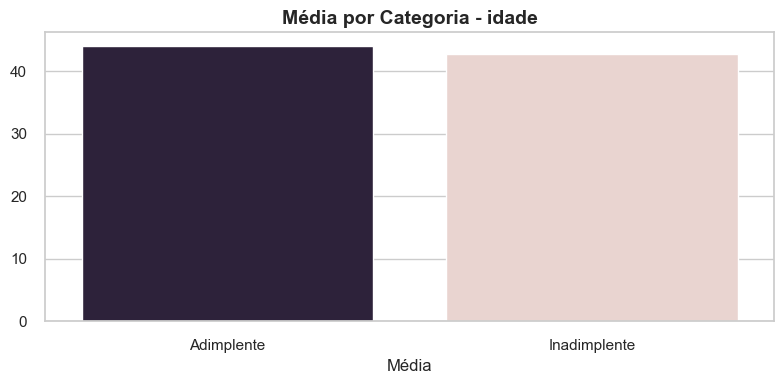

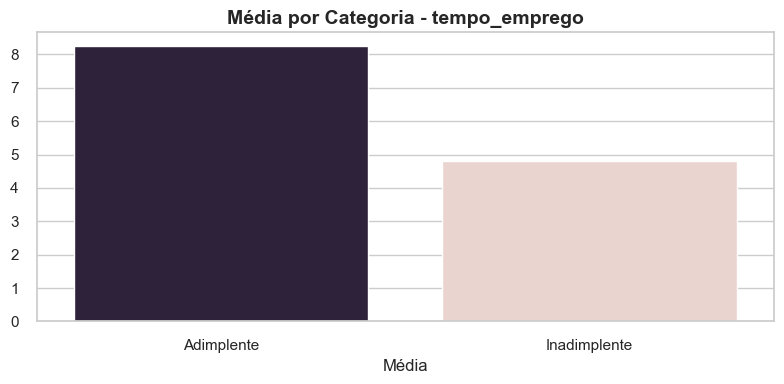

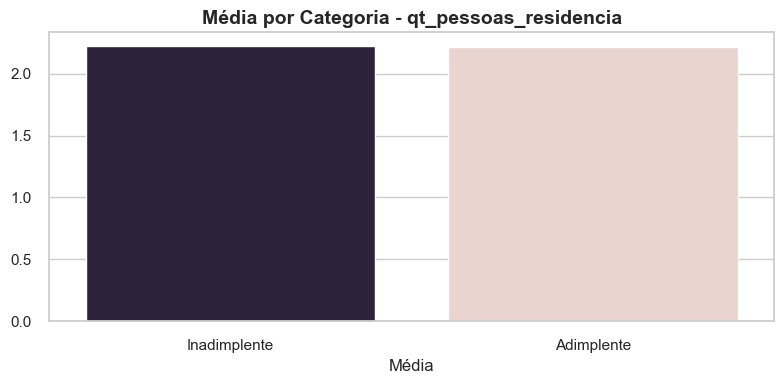

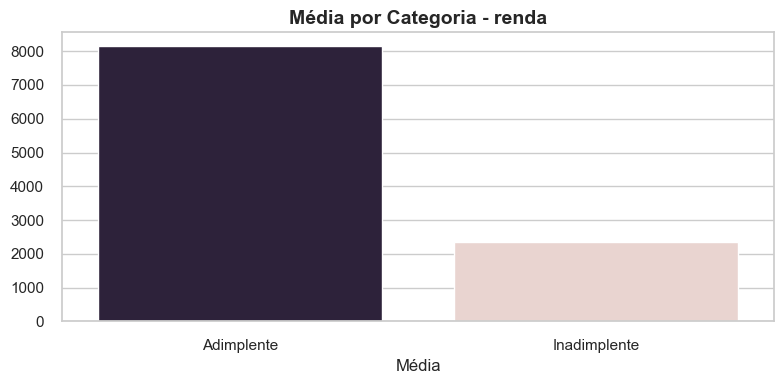

In [15]:
# Define o estilo dos gráficos
sns.set(style="whitegrid", palette="viridis")

# Lista das variáveis categóricas no mu DataFrame bivariado
variaveis = df_num['variavel'].unique()

# Loop para criar um gráfico por variável
for var in variaveis:
    temp = df_num[df_num['variavel'] == var].sort_values('media', ascending=False)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=temp,
        x='mau',
        y='media',
        hue='media',
        dodge=False,
        legend=False
    )
    
    plt.title(f'Média por Categoria - {var}', fontsize=14, weight='bold')
    plt.xlabel('Média')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

## Tratamento dos dados

### Valores Missings
Para tratar os valores missing da variável ```tempo_emprego```, optei por colocar a mediana da coluna nos valores faltantes.

A **mediana** é recomendado para evitar distorções por valores extremos, ou seja, *outliers*. Como será visto nos próximos gráficos, a variável ```tempo_emprego``` possui valores assimétricos, justificando o uso da mediana.

```python
df_tratado['tempo_emprego'] = df_tratado['tempo_emprego'].fillna(df_tratado['tempo_emprego'].median())
```

In [16]:
# Cópia de segurança para um df tratado
df_tratado = df_3_meses.copy()
df_tratado.drop(columns=['data_ref', 'index'], inplace=True)

df_tratado['tempo_emprego'] = (df_tratado['tempo_emprego']          # Seleciona a coluna que será aplicada a função
                               .fillna(df_tratado['tempo_emprego']  # fillna preenche os valores faltantes
                                       .median()))                    # Utiliza a mediana da coluna tempo_emprego

### Tempo_emprego após mediana

Percebe-se uma irrisória melhora no ```std``` e ```75%```.

### Outliers
Identificar os ```outliers``` é um processo delicado e demorado. De acordo com as análises anteriores do desvio padrão, irei estudar as variáveis:
- tempo_emprego
- renda

In [17]:
df_tratado['tempo_emprego_log'] = np.log1p(df_tratado['tempo_emprego']) # Aplicando o log1p, que evita erros com zeros e negativos
df_tratado['tempo_emprego_log'] = (df_tratado['tempo_emprego_log']      # Seleciona a coluna que será aplicada a função
                               .fillna(df_tratado['tempo_emprego_log']  # fillna preenche os valores faltantes
                                       .mean()))                        # Utiliza a média da coluna tempo_emprego

df_tratado['renda_log'] = np.log(df_tratado['renda'] + 1) # Aplicando o log + 1 para evitar valores negativos

df_tratado.describe().T

,count,mean,std,min,25%,50%,75%,max
qtd_filhos,150000.0,0.433413,0.737417,0.000000,0.000000,0.000000,1.000000,14.000000
idade,150000.0,43.829547,11.226707,22.000000,34.000000,43.000000,53.000000,68.000000
tempo_emprego,150000.0,7.464539,6.132101,0.117808,3.635616,6.038356,9.101370,42.906849
qt_pessoas_residencia,150000.0,2.212720,0.902114,1.000000,2.000000,2.000000,3.000000,15.000000
renda,150000.0,7301.344809,20778.675831,107.670000,1598.627500,2952.380000,5858.200000,732561.260000
tempo_emprego_log,150000.0,1.907399,0.690911,0.111370,1.533769,1.951375,2.312671,3.782070
renda_log,150000.0,8.094382,1.082238,4.688316,7.377526,7.990706,8.675768,13.504304


In [18]:
tempo_original = quantitativas['tempo_emprego'].describe().T
tempo_mediana = df_tratado['tempo_emprego'].describe().T
tempo_log = df_tratado['tempo_emprego_log'].describe().T
renda_original = quantitativas['renda'].describe().T
renda_log = df_tratado['renda_log'].describe().T

comparativo_tempo = pd.DataFrame({
    'Tempo_emprego original': tempo_original,
    'Tempo_emprego com mediana': tempo_mediana,
    'Tempo_emprego com log': tempo_log,
    'Renda original': renda_original,
    'Renda com log': renda_log
})

comparativo_tempo

,Tempo_emprego original,Tempo_emprego com mediana,Tempo_emprego com log,Renda original,Renda com log
count,124918.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,7.750898,7.464539,1.907399,7301.344809,8.094382
std,6.682998,6.132101,0.690911,20778.675831,1.082238
min,0.117808,0.117808,0.111370,107.670000,4.688316
25%,3.071233,3.635616,1.533769,1598.627500,7.377526
50%,6.038356,6.038356,1.951375,2952.380000,7.990706
75%,10.183562,9.101370,2.312671,5858.200000,8.675768
max,42.906849,42.906849,3.782070,732561.260000,13.504304


### Avaliação

O resultado do ```tempo_emprego``` com *log* melhorou exponencialmente. A **mean** caiu *75%* e o **std** estabilizou. Os valores dos **quartis** estão mais próximos. 

Há sinais de que os ```outliers``` da variável foram tratados.

O caso da ```renda``` é mais evidente. O processo de *log* foi assertivo e eficiente, diminuindo drasticamente todos os parâmetros, trazendo mais harmonia aos valores e simplicidade à análise.

In [19]:
# Função para criar um gráfico comparativo entre as variáveis antes e pós o log

def grafico_outlier(variavel):
    plt.figure(figsize=(10,4)) # Configura o tamanho do gráfico
    
    plt.subplot(1,2,1)   # Ajusta a posição do gráfico
    df_tratado[variavel].hist(bins=40)  # Faz o histograma na variavel escolhida
    plt.title('Antes do log')   # Título do gráfico
    
    plt.subplot(1,2,2)  # Ajusta a posição do gráfico
    df_tratado[variavel+'_log'].hist(bins=40)  # Faz o histograma na variável com log
    plt.title('Depois do log')  # Título do gráfico
   
    return
    plt.show()   # Plota o gráfico

### tempo_emprego_log

O pico no eixo *X*, próximo ao 2, indica que a maioria dos clientes estão nessa região. Antes do log, esses clientes estavam próximo a 8 anos.

A transformação logarítmica reduziu a cauda longa, mas manteve a concentração natural dos dados. O ```desvio padrão``` caiu de 6.1 para 0.9, comprovando essa concentração dos dados.

A diferença entre ```mínimo``` e ```máximo``` ficaram muito menores, evidenciando a correção de parte da assimetria.

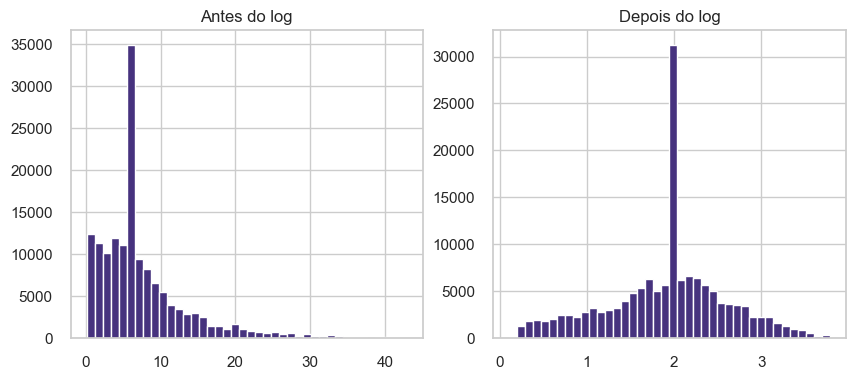

In [20]:
grafico_outlier('tempo_emprego')

### renda_log

Antes do *log*, a distribuição era extremamente assimétrica à direita, com valores muito altos puxando a média para cima. Em suma, a maioria das pessoas tem renda baixa/média, mas há alguns poucos com rendas altíssimas.

Não há dúvidas sobre os benefícios da aplicação do $log$ para ```renda```. A distribuição ficou mais simétrica, os *outliers* perderam força, a escala ficou mais interpretável, reduziu a variabilidade exagerada e aproximou a distruibuição da normalidade.

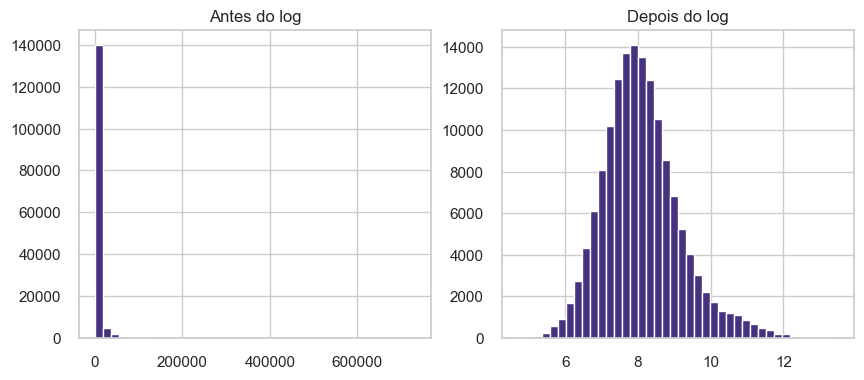

In [21]:
grafico_outlier('renda')

## Zeros estruturais

O ```zero estrutural``` é um valor que faz sentido existir - ou seja, não é uma falta de dado, mas uma condição real e significativa.

Pois bem, neste conjunto de dados temos duas colunas com ```zeros estruturais```:

### mau
Faz sentido ter o zero, visto que isso significa **False**.

### qtd_filhos
Nesta situação, vale apena estudar o caso.

| qtd_filhos | quantidade |
|------------|------------|
| 0          | 103449     |
| 1          | 30550      |
| 2          | 14029      |
| 3          | 1709       |
| 4          | 211        |
| 5          | 18         |
| 7          | 19         |
| 14         | 15         |

Casos com 14 filhos me parece *probabilisticamente improvável*. Para solucionar este problema, dividirei em grupos.

Além disso, analisarei as outras categorias.

In [22]:
print('Quantidade de zeros no dataframe')
print('#' * 32)

(df_tratado == 0).sum()

Quantidade de zeros no dataframe
################################


sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos               103449
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego                 0
qt_pessoas_residencia         0
renda                         0
mau                      128000
tempo_emprego_log             0
renda_log                     0
dtype: int64

In [23]:
print('Percentual de zeros por coluna')
print('#' * 30)

((df_tratado == 0).sum() / len(df_tratado) * 100).round(2)

Percentual de zeros por coluna
##############################


sexo                      0.00
posse_de_veiculo          0.00
posse_de_imovel           0.00
qtd_filhos               68.97
tipo_renda                0.00
educacao                  0.00
estado_civil              0.00
tipo_residencia           0.00
idade                     0.00
tempo_emprego             0.00
qt_pessoas_residencia     0.00
renda                     0.00
mau                      85.33
tempo_emprego_log         0.00
renda_log                 0.00
dtype: float64

In [24]:
df_tratado['qtd_filhos'].value_counts()

qtd_filhos
0     103449
1      30550
2      14029
3       1709
4        211
7         19
5         18
14        15
Name: count, dtype: int64

## Agrupamentos de categorias

In [25]:
# Criei esse dataframe com renda_log para armazenar os grupos.

df_final = df_tratado[['renda_log', 'mau']]

df_final

,renda_log,mau
600000,7.996482,True
600001,8.745025,False
600002,9.547611,False
600003,7.964437,False
600004,7.915052,False
...,...,...
749995,7.654912,False
749996,7.237340,False
749997,6.477065,True
749998,8.347050,True


In [26]:
def biv_discreta(var, df_tratado):
    df_tratado['bom'] = 1-df_tratado.mau
    g = df_tratado.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df_final.mau.mean()
    woe_geral = np.log(df_final.mau.mean() / (1 - df_final.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()

    plt.subplots_adjust(hspace=0.5)
    return display(biv) 

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,88554,14895,0.143984,0,103449,0.001092,0.146123,0.141845,-1.782587,-1.765335,-1.800053,-0.021599,-0.004348,-0.039065
1,25798,4752,0.155548,1,30550,0.002074,0.159613,0.151484,-1.691731,-1.661114,-1.723009,0.069256,0.099874,0.037979
2,11960,2069,0.147480,2,14029,0.002994,0.153348,0.141612,-1.754502,-1.708578,-1.801964,0.006485,0.052410,-0.040976
3,1458,251,0.146870,3,1709,0.008563,0.163664,0.130075,-1.759368,-1.631217,-1.900293,0.001620,0.129771,-0.139305
4,193,18,0.085308,4,211,0.019231,0.123218,0.047398,-2.372318,-1.962306,-3.000607,-0.611331,-0.201318,-1.239620
5,14,4,0.222222,5,18,0.097991,0.428965,0.015480,-1.252763,-0.286076,-4.152623,0.508225,1.474911,-2.391635
7,14,5,0.263158,7,19,0.101023,0.475399,0.050917,-1.029619,-0.098485,-2.925294,0.731368,1.662502,-1.164306
14,9,6,0.400000,14,15,0.126491,0.671296,0.128704,-0.405465,0.714055,-1.912470,1.355523,2.475042,-0.151483


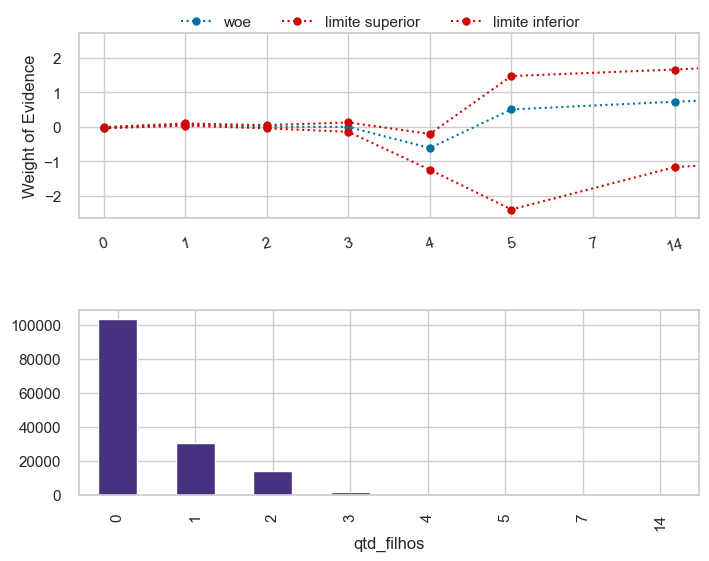

In [27]:
biv_discreta('qtd_filhos', df_tratado);

,qt_bom,qt_mau,mau,grupo_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
grupo_filhos,,,,,,,,,,,,,,
1-2 filhos,37758,6821,0.153009,1-2 filhos,44579,0.001705,0.156351,0.149667,-1.711191,-1.685632,-1.737212,0.049797,0.075356,0.023775
3 ou mais filhos,1688,284,0.144016,3 ou mais filhos,1972,0.007907,0.159522,0.128510,-1.782325,-1.661787,-1.914196,-0.021338,0.099201,-0.153208
Sem filhos,88554,14895,0.143984,Sem filhos,103449,0.001092,0.146123,0.141845,-1.782587,-1.765335,-1.800053,-0.021599,-0.004348,-0.039065


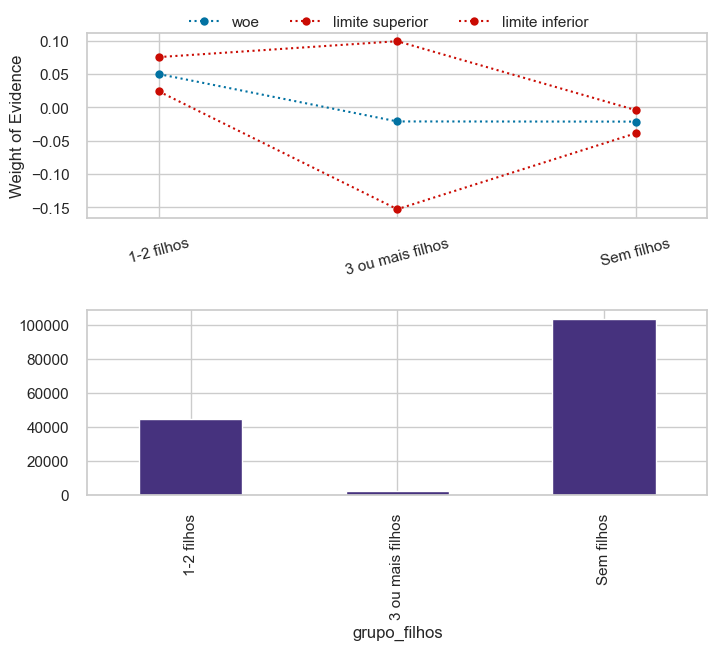

In [28]:
def agrupar_filhos(x):
    if x == 0:
        return 'Sem filhos'
    elif x in [1,2]:
        return '1-2 filhos'
    else:
        return '3 ou mais filhos'

df_final['grupo_filhos'] = df_tratado['qtd_filhos'].apply(agrupar_filhos)

biv_discreta('grupo_filhos', df_final);

In [29]:
IV(df_final['grupo_filhos'], df_final['mau'])

0.0010752229697544133

### Agrupamento: qtd_filhos

Subdividi em 3 grupos:
- **0** filhos
- **1** - **2** filhos
- **3** ou mais filhos

Antes do agrupamento havia muito ruído, os limites de confiança (*sup* e *inf*) flutuavam bastante e distorciam o ```woe```.

Após a separação, percebi que as categorias adquiriram contagens razoáveis (*count*), reduziu o ```erro padrão``` (*ep*) e estabilizou o ```woe```.

Em suma, agrupamento melhorou significativamente a análise.

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,1369,305,0.182198,Fundamental,1674,0.009434,0.200703,0.163694,-1.501524,-1.381907,-1.630998,0.259464,0.379081,0.129990
Médio,86167,15220,0.150118,Médio,101387,0.001122,0.152317,0.147919,-1.733677,-1.716547,-1.751015,0.027311,0.044441,0.009973
Pós graduação,145,16,0.099379,Pós graduação,161,0.023578,0.145943,0.052815,-2.204145,-1.766782,-2.886702,-0.443157,-0.005795,-1.125714
Superior completo,35330,5536,0.135467,Superior completo,40866,0.001693,0.138785,0.132149,-1.853460,-1.825416,-1.882090,-0.092472,-0.064429,-0.121102
Superior incompleto,4989,923,0.156123,Superior incompleto,5912,0.004721,0.165377,0.146869,-1.687362,-1.618749,-1.759373,0.073626,0.142238,0.001615


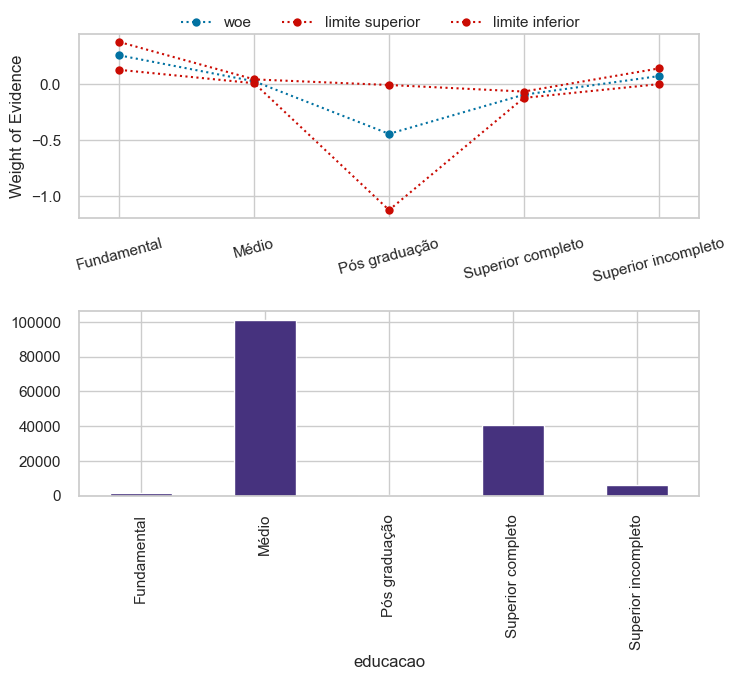

In [30]:
biv_discreta('educacao', df_tratado);

,qt_bom,qt_mau,mau,grupo_educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
grupo_educacao,,,,,,,,,,,,,,
Ensino Escolar (fundamental/médio),87536,15525,0.150639,Ensino Escolar (fundamental/médio),103061,0.001114,0.152823,0.148455,-1.729599,-1.712631,-1.746770,0.031389,0.048357,0.014218
Superior Completo e/ou Pós,35475,5552,0.135326,Superior Completo e/ou Pós,41027,0.001689,0.138636,0.132015,-1.854670,-1.826669,-1.883255,-0.093682,-0.065681,-0.122267
Superior incompleto,4989,923,0.156123,Superior incompleto,5912,0.004721,0.165377,0.146869,-1.687362,-1.618749,-1.759373,0.073626,0.142238,0.001615


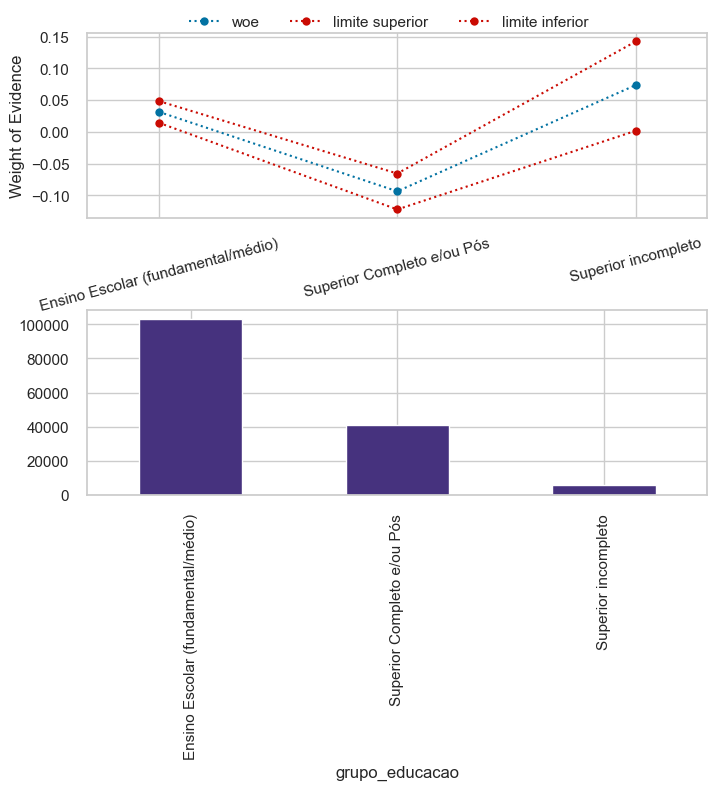

In [31]:
df_final['grupo_educacao'] = df_tratado['educacao'].replace({
    'Pós graduação': 'Superior completo',
    'Fundamental': 'Médio',
})

df_final['grupo_educacao'] = df_final['grupo_educacao'].replace({
    'Superior completo': 'Superior Completo e/ou Pós',
    'Médio': 'Ensino Escolar (fundamental/médio)'
})

biv_discreta('grupo_educacao', df_final);

In [32]:
IV(df_final['grupo_educacao'], df_final['mau']).round(4)

0.0032

### Agrupamento: educação

O comportamento de risco manteve-se coerente com o esperado: quanto *maior* o nível educacional, *menor* a taxa de inadimplência.

A fusão de **Superior Completo** + **Pós Graduação** trouxe robustez estatística, pois diminui as categorias e, consequentemente, a variância. Além disso, o ```ep``` da nova faixa caiu, tornando o ```WOE``` mais confiável.

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,1750,337,0.161476,Aluguel,2087,0.008055,0.177272,0.145680,-1.647288,-1.534941,-1.768896,0.113700,0.226047,-0.007908
Casa,115401,19557,0.144912,Casa,134958,0.000958,0.146790,0.143034,-1.775080,-1.760004,-1.790318,-0.014092,0.000984,-0.029331
Com os pais,5353,1149,0.176715,Com os pais,6502,0.004730,0.185988,0.167442,-1.538765,-1.476294,-1.603866,0.222223,0.284693,0.157121
Comunitário,563,93,0.141768,Comunitário,656,0.013619,0.168510,0.115026,-1.800680,-1.596223,-2.040396,-0.039692,0.164765,-0.279408
Estúdio,971,128,0.116470,Estúdio,1099,0.009676,0.135456,0.097483,-2.026296,-1.853555,-2.225509,-0.265308,-0.092567,-0.464522
Governamental,3962,736,0.156662,Governamental,4698,0.005303,0.167059,0.146266,-1.683274,-1.606617,-1.764193,0.077714,0.154371,-0.003206


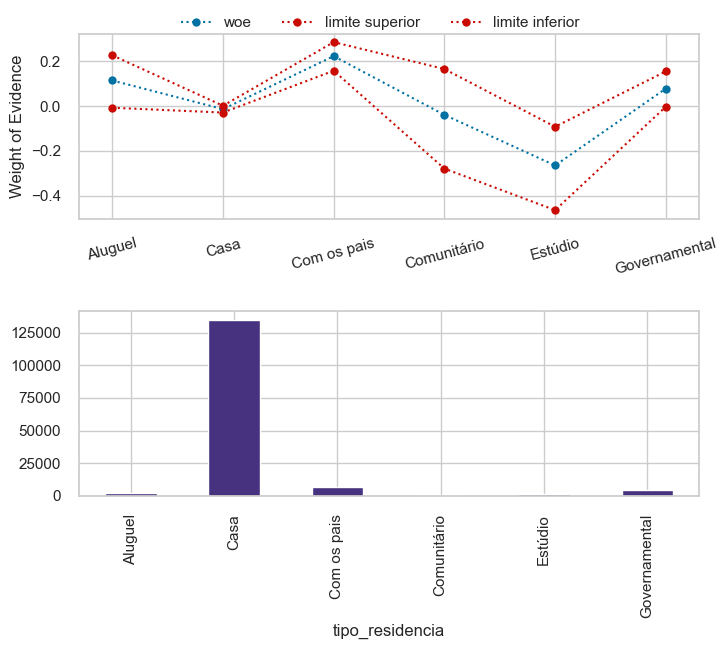

In [33]:
biv_discreta('tipo_residencia', df_tratado);

,qt_bom,qt_mau,mau,grupo_tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
grupo_tipo_residencia,,,,,,,,,,,,,,
Alta estabilidade,116935,19778,0.144668,Alta estabilidade,136713,0.000951,0.146533,0.142803,-1.777048,-1.762059,-1.792199,-0.016060,-0.001071,-0.031211
Baixa estabilidade,5353,1149,0.176715,Baixa estabilidade,6502,0.004730,0.185988,0.167442,-1.538765,-1.476294,-1.603866,0.222223,0.284693,0.157121
Média estabilidade,5712,1073,0.158143,Média estabilidade,6785,0.004430,0.166826,0.149459,-1.672111,-1.608288,-1.738847,0.088877,0.152700,0.022141


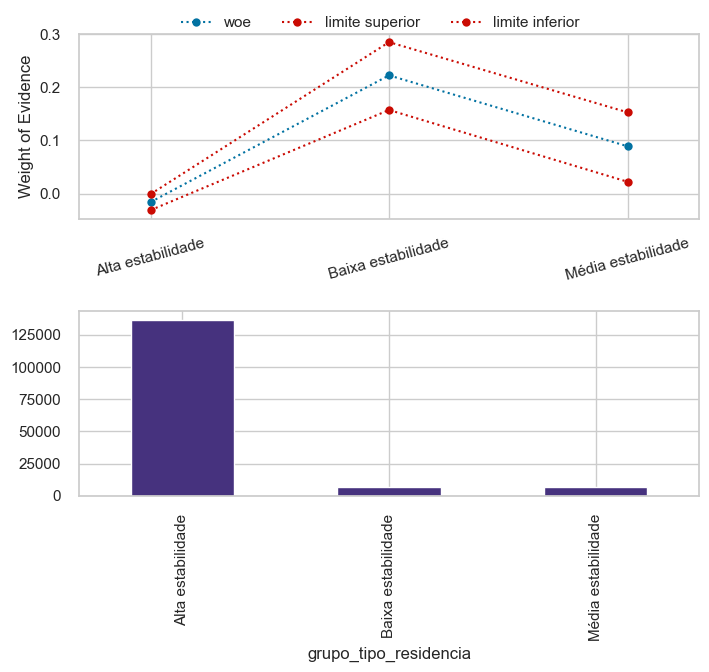

In [34]:
df_final['grupo_tipo_residencia'] = df_tratado['tipo_residencia'].replace({
    'Casa': 'Alta estabilidade',
    'Comunitário': 'Alta estabilidade',
    'Estúdio': 'Alta estabilidade',
    'Governamental': 'Média estabilidade',
    'Aluguel': 'Média estabilidade',
    'Com os pais': 'Baixa estabilidade'
})

biv_discreta('grupo_tipo_residencia', df_final);

In [35]:
IV(df_final['grupo_tipo_residencia'], df_final['mau']).round(4)

0.0029

### Agrupamento: tipo_residencia

Para simplificar e garantir estabilidade estatística, dividi em 3 grupos. Levei em conta a *taxa de mau* e *WOE*.

- ```Alta estabilidade```: Estúdio, Comunitário, Casa
- ```Média estabilidade```: Governamental, Aluguel
- ```Baixa estabilidade```: Com os pais

A união também simplificou a variável, trazendo robustez estatística; reduziu o ruído, diminui o ```ep``` e preservou a ordem natural do risco, ou seja, moradia estável carrega menor risco.

,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
1.0,23008,4103,0.151341,1.0,27111,0.002177,0.155607,0.147075,-1.724124,-1.691285,-1.757732,0.036864,0.069703,0.003256
2.0,70053,11542,0.141455,2.0,81595,0.001220,0.143846,0.139064,-1.803260,-1.783708,-1.823090,-0.042272,-0.022720,-0.062102
3.0,21845,4097,0.157929,3.0,25942,0.002264,0.162367,0.153491,-1.673717,-1.640720,-1.707476,0.087271,0.120267,0.053512
4.0,11460,1985,0.147639,4.0,13445,0.003059,0.153635,0.141642,-1.753244,-1.706369,-1.801721,0.007744,0.054619,-0.040733
5.0,1404,240,0.145985,5.0,1644,0.008708,0.163066,0.128905,-1.766442,-1.635590,-1.910678,-0.005454,0.125398,-0.149690
6.0,196,22,0.100917,6.0,218,0.020401,0.141127,0.060708,-2.187072,-1.805959,-2.739057,-0.426084,-0.044971,-0.978069
7.0,11,0,0.000000,7.0,11,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
9.0,14,5,0.263158,9.0,19,0.101023,0.475399,0.050917,-1.029619,-0.098485,-2.925294,0.731368,1.662502,-1.164306
15.0,9,6,0.400000,15.0,15,0.126491,0.671296,0.128704,-0.405465,0.714055,-1.912470,1.355523,2.475042,-0.151483


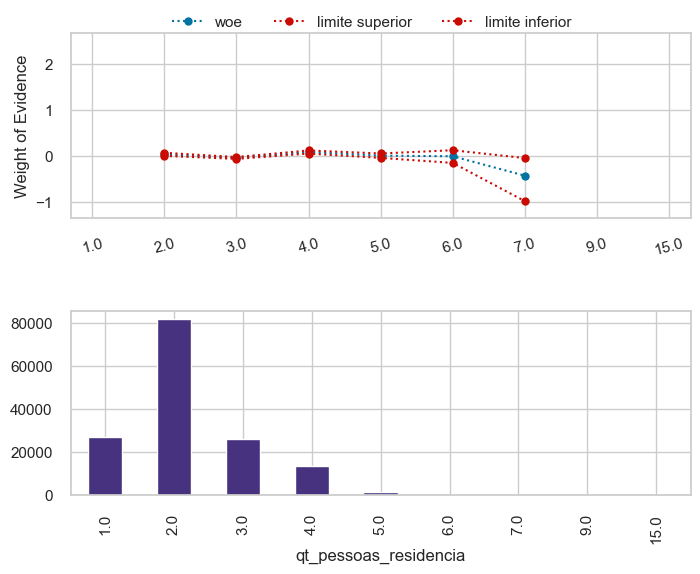

In [36]:
biv_discreta('qt_pessoas_residencia', df_tratado);

,qt_bom,qt_mau,mau,grupo_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
grupo_pessoas_residencia,,,,,,,,,,,,,,
1-2 pessoas,93061,15645,0.143920,1-2 pessoas,108706,0.001065,0.146007,0.141834,-1.783104,-1.766269,-1.800143,-0.022116,-0.005281,-0.039155
3-4 pessoas,33305,6082,0.154416,3-4 pessoas,39387,0.001821,0.157985,0.150848,-1.700374,-1.673297,-1.727968,0.060614,0.087691,0.033020
5 ou mais pessoas,1634,273,0.143157,5 ou mais pessoas,1907,0.008020,0.158886,0.127428,-1.789314,-1.666541,-1.923897,-0.028327,0.094447,-0.162909


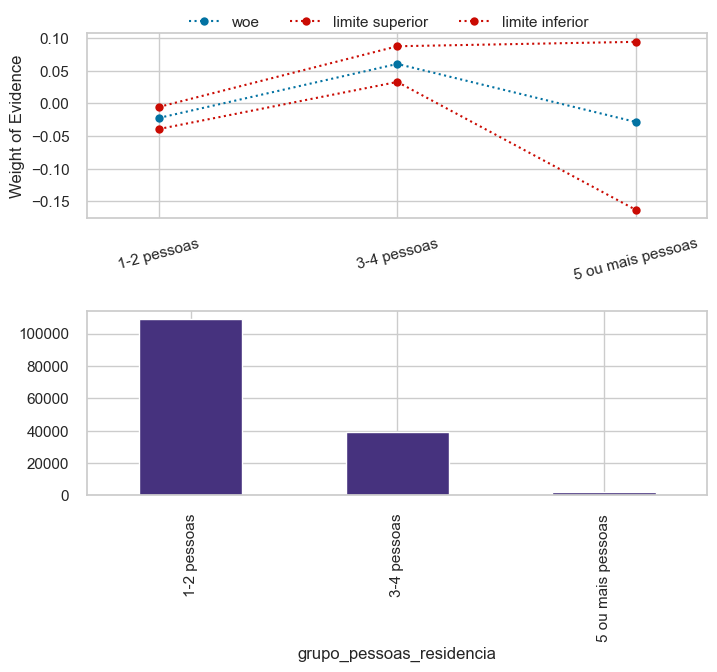

In [37]:
def agrupar_pessoas_residencia(x):
    if x in [1,2]:
        return '1-2 pessoas'
    elif x in [3,4]:
        return '3-4 pessoas'
    else:
        return '5 ou mais pessoas'

df_final['grupo_pessoas_residencia'] = df_tratado['qt_pessoas_residencia'].apply(agrupar_pessoas_residencia)

biv_discreta('grupo_pessoas_residencia', df_final);

In [38]:
IV(df_final['grupo_pessoas_residencia'],df_final['mau'])

0.0013473385162301068

### Agrupamento qt_pessoas_residencia

Originalmente, havia muitos grupos com poucos registros, trazendo instabilidade para o ```WOE``` e valores altíssimos para ```ep```. A interpretação estava difícil, com valores extremos chegando a *-inf*. Também ocorreu o problema com zero estrutural visto em aula, com o grupo de **7** pessoas.

Com a separação em 3 grupos, o ```WOE``` melhorou , o ```ep``` diminui e a interpretabilidade facilitou. 
Apesar de trazer melhoras para a variável, acredito que esta não seja discriminante.

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,85632,15143,0.150265,F,100775,0.001126,0.152472,0.148059,-1.732521,-1.715346,-1.749905,0.028467,0.045642,0.011083
M,42368,6857,0.139299,M,49225,0.001561,0.142358,0.136240,-1.821123,-1.795841,-1.846875,-0.060136,-0.034854,-0.085887


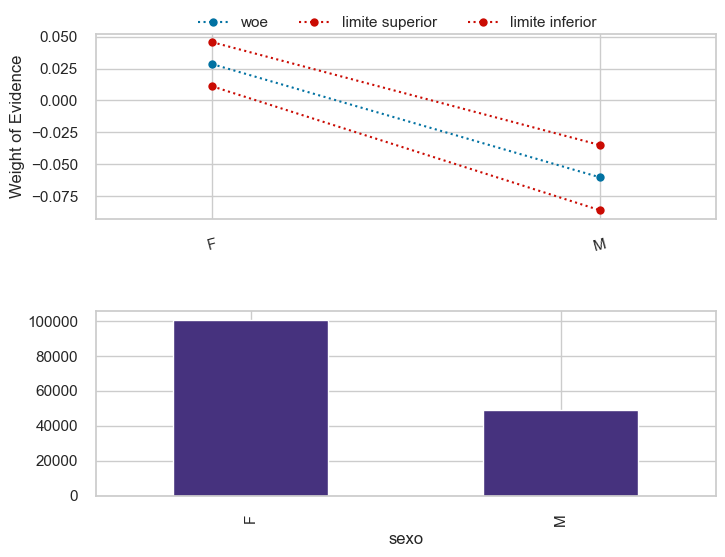

In [39]:
biv_discreta('sexo', df_tratado);

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,78094,13567,0.148013,N,91661,0.001173,0.150312,0.145714,-1.750273,-1.732158,-1.768621,0.010715,0.028830,-0.007634
S,49906,8433,0.144552,S,58339,0.001456,0.147405,0.141698,-1.777989,-1.755099,-1.801257,-0.017001,0.005889,-0.040269


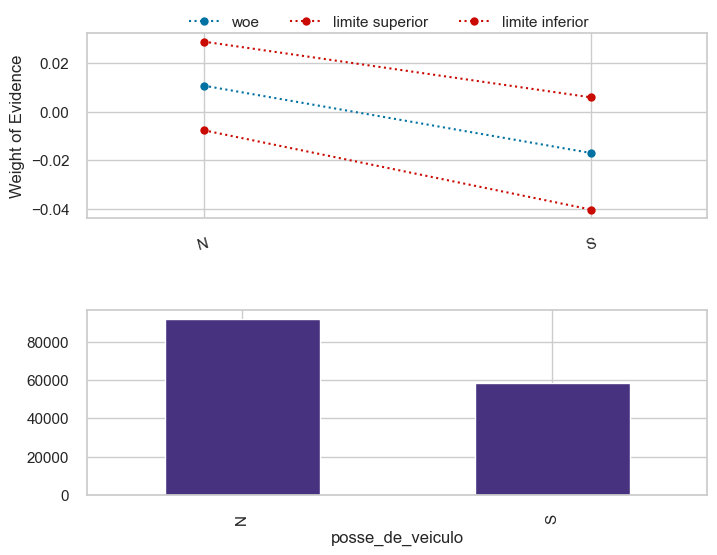

In [40]:
biv_discreta('posse_de_veiculo', df_tratado);

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,41210,8152,0.165147,N,49362,0.001671,0.168423,0.161872,-1.620418,-1.596845,-1.644368,0.140570,0.164142,0.116620
S,86790,13848,0.137602,S,100638,0.001086,0.139730,0.135474,-1.835351,-1.817531,-1.853404,-0.074363,-0.056543,-0.092416


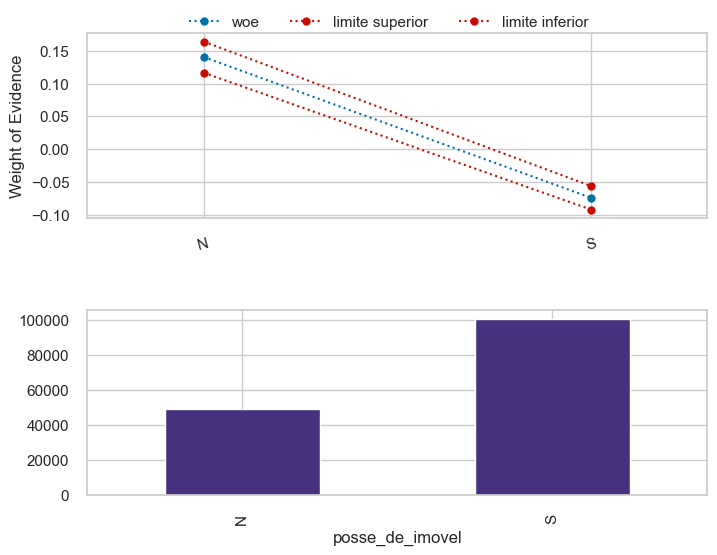

In [41]:
biv_discreta('posse_de_imovel', df_tratado);

### sexo, posse_de_imovel, posse_de_veiculo

Para estas variáveis não vejo possibilidade de alterações, visto que são binárias.

In [42]:
df_final['sexo'] = df_tratado['sexo']
df_final['posse_de_imovel'] = df_tratado['posse_de_imovel']
df_final['posse_de_veiculo'] = df_tratado['posse_de_veiculo']

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,90073,15250,0.144793,Casado,105323,0.001084,0.146918,0.142667,-1.776041,-1.758982,-1.793309,-0.015053,0.002006,-0.032321
Separado,7096,1287,0.153525,Separado,8383,0.003937,0.161243,0.145807,-1.707217,-1.649008,-1.767874,0.053770,0.111980,-0.006886
Solteiro,15629,2809,0.152348,Solteiro,18438,0.002646,0.157536,0.147161,-1.716300,-1.676679,-1.757043,0.044688,0.084309,0.003945
União,9798,1779,0.153667,União,11577,0.003352,0.160237,0.147097,-1.706127,-1.656469,-1.757554,0.054861,0.104519,0.003433
Viúvo,5404,875,0.139353,Viúvo,6279,0.004370,0.147921,0.130786,-1.820671,-1.751001,-1.894028,-0.059683,0.009987,-0.133041


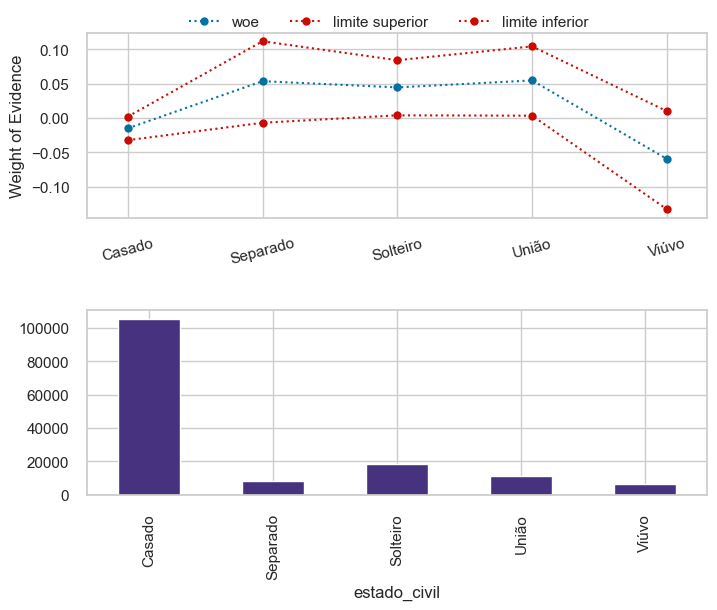

In [43]:
biv_discreta('estado_civil', df_tratado);

,qt_bom,qt_mau,mau,grupo_estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
grupo_estado_civil,,,,,,,,,,,,,,
Casado/União,99871,17029,0.145672,Casado/União,116900,0.001032,0.147694,0.143649,-1.768962,-1.752805,-1.785306,-0.007974,0.008183,-0.024318
Solteiro,22725,4096,0.152716,Solteiro,26821,0.002196,0.157021,0.148411,-1.713455,-1.680560,-1.747118,0.047533,0.080428,0.013869
Viúvo,5404,875,0.139353,Viúvo,6279,0.004370,0.147921,0.130786,-1.820671,-1.751001,-1.894028,-0.059683,0.009987,-0.133041


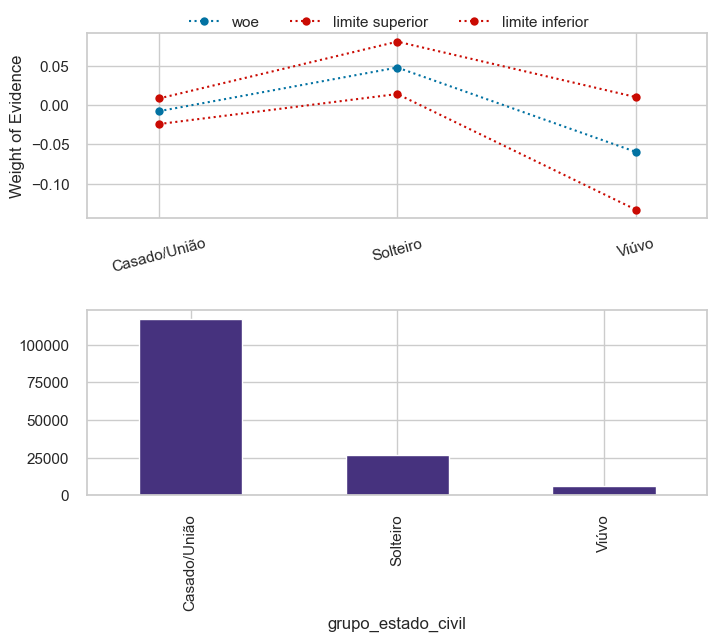

In [44]:
df_final['grupo_estado_civil'] = df_tratado['estado_civil'].replace({
    'Casado': 'Casado/União',
    'Separado': 'Solteiro',
    'Solteiro': 'Solteiro',
    'União': 'Casado/União',
    'Viúvo': 'Viúvo'
})

biv_discreta('grupo_estado_civil', df_final);

In [45]:
IV(df_final['grupo_estado_civil'], df_final['mau'])

0.0006062139098043698

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,65662,11618,0.150336,Assalariado,77280,0.001286,0.152856,0.147817,-1.731965,-1.712372,-1.751830,0.029023,0.048616,0.009158
Bolsista,67,3,0.042857,Bolsista,70,0.024208,0.091150,-0.005436,-3.106080,-2.299675,NaN,-1.345093,-0.538687,NaN
Empresário,29573,4998,0.144572,Empresário,34571,0.001891,0.148279,0.140865,-1.777824,-1.748162,-1.808125,-0.016836,0.012826,-0.047137
Pensionista,21198,3940,0.156735,Pensionista,25138,0.002293,0.161229,0.152240,-1.682726,-1.649111,-1.717136,0.078262,0.111877,0.043852
Servidor público,11500,1441,0.111352,Servidor público,12941,0.002765,0.116772,0.105931,-2.077010,-2.023362,-2.132992,-0.316022,-0.262375,-0.372004


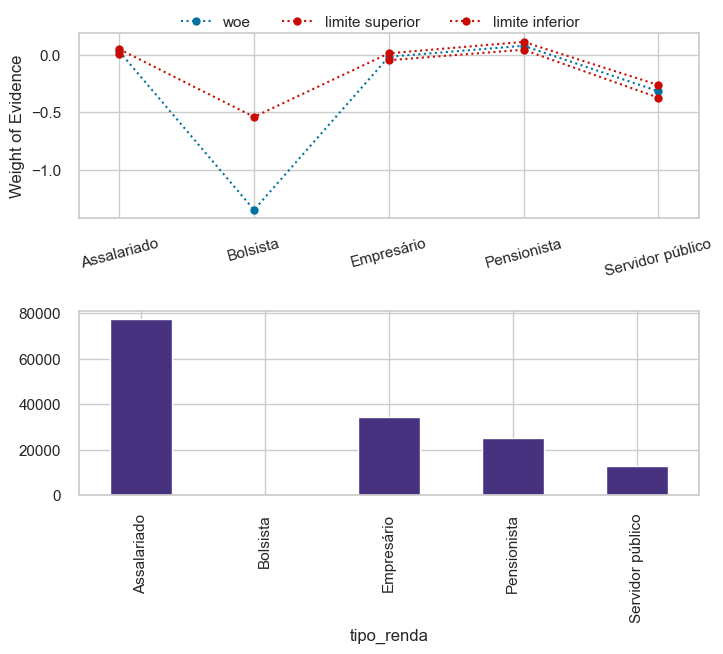

In [46]:
biv_discreta('tipo_renda', df_tratado);

,qt_bom,qt_mau,mau,grupo_tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
grupo_tipo_renda,,,,,,,,,,,,,,
Assalariado,65662,11618,0.150336,Assalariado,77280,0.001286,0.152856,0.147817,-1.731965,-1.712372,-1.751830,0.029023,0.048616,0.009158
Empresário,29573,4998,0.144572,Empresário,34571,0.001891,0.148279,0.140865,-1.777824,-1.748162,-1.808125,-0.016836,0.012826,-0.047137
Pensionista,21198,3940,0.156735,Pensionista,25138,0.002293,0.161229,0.152240,-1.682726,-1.649111,-1.717136,0.078262,0.111877,0.043852
Servidor público + Bolsistas,11567,1444,0.110983,Servidor público + Bolsistas,13011,0.002754,0.116381,0.105585,-2.080739,-2.027159,-2.136651,-0.319751,-0.266171,-0.375663


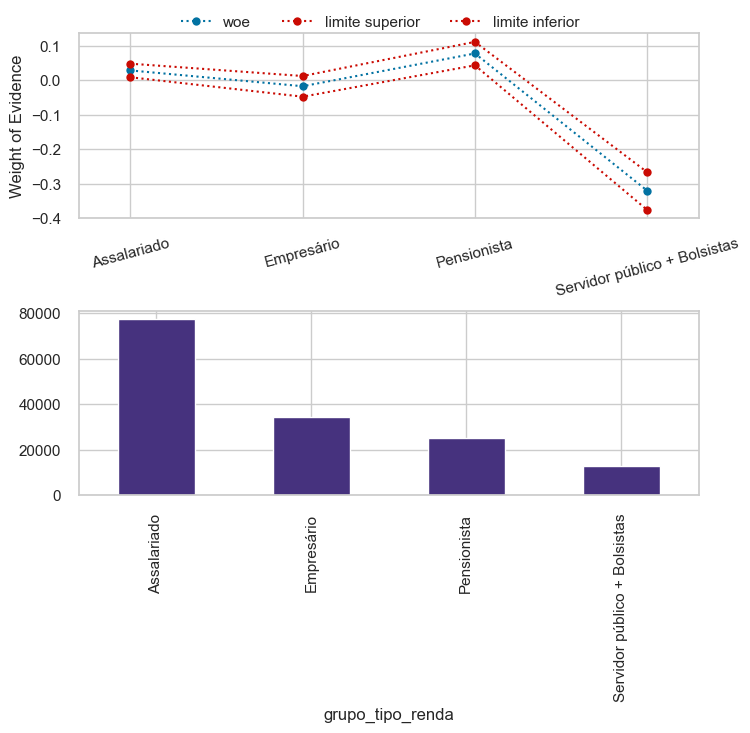

In [47]:
df_final['grupo_tipo_renda'] = df_tratado['tipo_renda'].replace({
    'Bolsista': 'Servidor público',
})

df_final['grupo_tipo_renda'] = df_final['grupo_tipo_renda'].replace({
    'Servidor público': 'Servidor público + Bolsistas'
})

biv_discreta('grupo_tipo_renda', df_final);

In [48]:
IV(df_final['grupo_tipo_renda'], df_final['mau'])

0.009466181350017328

### Agrupamento: tipo_renda

Encontrei alguns problemas nesta categoria. O ```count``` para **Bolsista** é extremamente pequena, instável, tornando-a difícil de interpretar. Para sanar isso, agrupei com **Servidor Público**, dado que era a menor variável. Estes grupos minúsculos são problemáticos justamente porque influenciam pouco o modelo, mas podem gerar *outliers* na análise.

Com o agrupamento, os valores extremos de ```WOE```foram removidos, melhorou a confiabilidade dos intervalos de confiança (```mau_sup``` / ```mau_inf```), manteve a discriminação dos grupos grandes e médios. Desta maneira, facilitou a interpretação dos dados.

,qt_bom,qt_mau,mau,idade,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
idade,,,,,,,,,,,,,,
22,83,13,0.135417,22,96,0.034922,0.204746,0.066087,-1.853891,-1.356889,-2.648412,-0.092903,0.404099,-0.887424
23,209,61,0.225926,23,270,0.025450,0.276033,0.175819,-1.231460,-0.964225,-1.544936,0.529527,0.796762,0.216052
24,773,198,0.203913,24,971,0.012930,0.229287,0.178540,-1.362012,-1.212340,-1.526272,0.398976,0.548647,0.234716
25,1136,282,0.198872,25,1418,0.010600,0.219665,0.178079,-1.393362,-1.267621,-1.529420,0.367626,0.493367,0.231568
26,1450,356,0.197121,26,1806,0.009361,0.215481,0.178761,-1.404388,-1.292200,-1.524766,0.356600,0.468788,0.236222
27,3450,860,0.199536,27,4310,0.006088,0.211471,0.187601,-1.389197,-1.316083,-1.465673,0.371791,0.444905,0.295315
28,3459,781,0.184198,28,4240,0.005953,0.195870,0.172527,-1.488160,-1.412313,-1.567825,0.272828,0.348675,0.193163
29,2986,612,0.170094,29,3598,0.006264,0.182375,0.157814,-1.584958,-1.500337,-1.674585,0.176030,0.260650,0.086403
30,3343,745,0.182241,30,4088,0.006038,0.194078,0.170403,-1.501240,-1.423726,-1.582772,0.259748,0.337262,0.178216


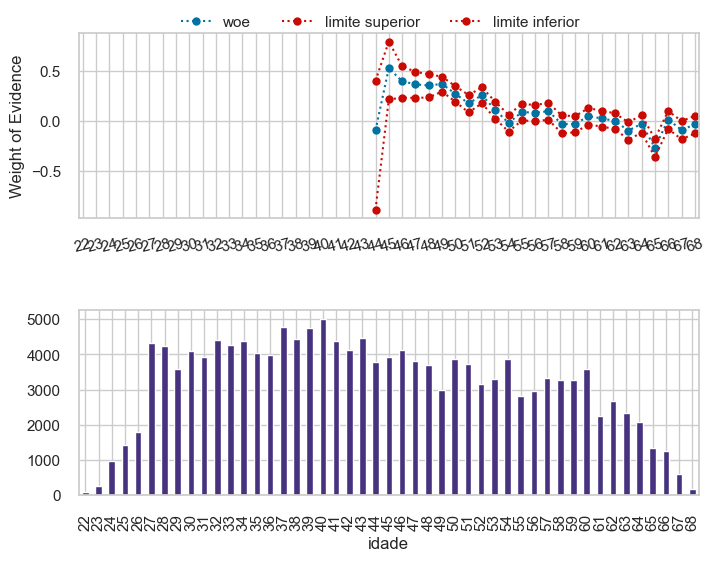

In [49]:
biv_discreta('idade', df_tratado);

,qt_bom,qt_mau,mau,grupo_idade,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
grupo_idade,,,,,,,,,,,,,,
22-35,34632,7185,0.171820,22-35,41817,0.001845,0.175436,0.168204,-1.572783,-1.547583,-1.598406,0.188205,0.213405,0.162581
36-45,37433,6170,0.141504,36-45,43603,0.001669,0.144776,0.138232,-1.802854,-1.776179,-1.830049,-0.041866,-0.015191,-0.069061
46-59,41968,6256,0.129728,46-59,48224,0.001530,0.132727,0.126729,-1.903366,-1.877060,-1.930195,-0.142379,-0.116072,-0.169207
60+,13967,2389,0.146063,60+,16356,0.002761,0.151475,0.140650,-1.765823,-1.723076,-1.809904,-0.004835,0.037912,-0.048916


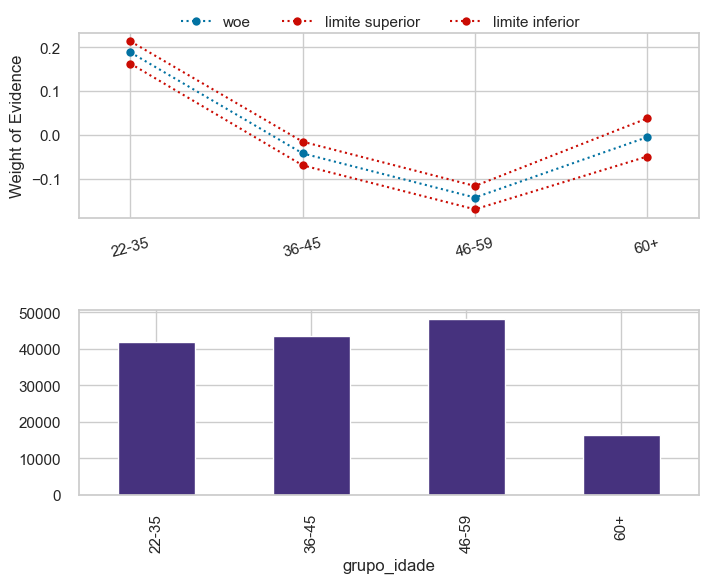

In [50]:
def agrupar_idade(x):
    if 22 <= x <= 35:
        return '22-35'
    elif 36 <= x <= 45:
        return '36-45'
    elif 46 <= x <= 59:
        return '46-59'
    else:
        return '60+'        

df_final['grupo_idade'] = df_tratado['idade'].apply(agrupar_idade)

biv_discreta('grupo_idade', df_final);

### Agrupamento: idade

Separei em 4 grupos:
- 22 até 35
- 36 até 45
- 46 até 59
- 60+ (*idosos*)

A maior dificuldade que encontrei no modelo sem agrupamento foi a **interpretabilidade do gráfico**, havia muito ruído, tornando-o difícil de entender.
Além disso, as extremidades estavam com poucos registros (idades de 22,23,67,68 anos, por exemplo), gerando intervalos de confiança muito amplos. Essa insuficiência também causa ```logits``` e ```WOE``` instáveis, podendo gerar valores extremos e *outliers*.

Após o agrupamento, é nítido que a interpretação do gráfico melhorou exponencialmente. Cada faixa agora tem mais obervações, o que reduz a *variablidade* e *estabiliza* os indicadores de uma forma geral. Outro ponto importante são os *limites superiores*(```mau/sup```) e *limites inferiores*(```mau/inf```) que agora são estreitos, refletindo maior confiança nos valores médios.

In [51]:
df_final['tempo_emprego_log'] = df_tratado['tempo_emprego_log']

df_final.columns

Index(['renda_log', 'mau', 'grupo_filhos', 'bom', 'grupo_educacao',
       'grupo_tipo_residencia', 'grupo_pessoas_residencia', 'sexo',
       'posse_de_imovel', 'posse_de_veiculo', 'grupo_estado_civil',
       'grupo_tipo_renda', 'grupo_idade', 'tempo_emprego_log'],
      dtype='object')

In [52]:
formula = 'mau ~ sexo + posse_de_veiculo + posse_de_imovel + grupo_filhos + grupo_tipo_renda + grupo_educacao + grupo_estado_civil + grupo_tipo_residencia + grupo_idade + tempo_emprego_log + grupo_pessoas_residencia + renda_log' 

r1 = smf.glm(formula, data=df_final, family=sm.families.Binomial()).fit()

r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               150000
Model:                                     GLM   Df Residuals:                   149978
Model Family:                         Binomial   Df Model:                           21
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -55312.
Date:                         Fri, 24 Oct 2025   Deviance:                   1.1062e+05
Time:                                 09:26:36   Pearson chi2:                 1.51e+05
No. Iterations:                              6   Pseudo R-squ. (CS):            0.09178
Covariance Type:                     nonrobust                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -5.9583      0.088    -67.950      0.000      -6.130      -5.786
sexo[T.M]                                            0.0117      0.018      0.639      0.523      -0.024       0.048
posse_de_veiculo[T.S]                               -0.0041      0.017     -0.237      0.812      -0.038       0.030
posse_de_imovel[T.S]                                 0.0245      0.017      1.472      0.141      -0.008       0.057
grupo_filhos[T.3 ou mais filhos]                    -0.3074      0.364     -0.845      0.398      -1.020       0.406
grupo_filhos[T.Sem filhos]                          -0.0260      0.046     -0.563      0.573      -0.117       0.065
grupo_tipo_renda[T.Empresário]                      -0.0077      0.020     -0.391      0.695      -0.046       0.031
grupo_tipo_renda[T.Pensionista]                      0.0078      0.029      0.268      0.788      -0.049       0.065
grupo_tipo_renda[T.Servidor público + Bolsistas]    -0.0232      0.032     -0.730      0.465      -0.085       0.039
grupo_educacao[T.Superior Completo e/ou Pós]         0.0013      0.018      0.068      0.946      -0.035       0.038
grupo_educacao[T.Superior incompleto]               -0.0151      0.040     -0.382      0.703      -0.093       0.062
grupo_estado_civil[T.Solteiro]                      -0.0091      0.023     -0.405      0.685      -0.053       0.035
grupo_estado_civil[T.Viúvo]                          0.0275      0.041      0.671      0.502      -0.053       0.108
grupo_tipo_residencia[T.Baixa estabilidade]         -0.0066      0.036     -0.182      0.856      -0.078       0.065
grupo_tipo_residencia[T.Média estabilidade]         -0.0347      0.037     -0.946      0.344      -0.107       0.037
grupo_idade[T.36-45]                                -0.0186      0.020     -0.908      0.364      -0.059       0.022
grupo_idade[T.46-59]                                -0.0091      0.024     -0.387      0.698      -0.055       0.037
grupo_idade[T.60+]                                  -0.0546      0.038     -1.441      0.149      -0.129       0.020
grupo_pessoas_residencia[T.3-4 pessoas]             -0.0213      0.049     -0.435      0.663      -0.117       0.075
grupo_pessoas_residencia[T.5 ou mais pessoas]        0.3730      0.374      0.997      0.319      -0.360       1.106
tempo_emprego_log                                    0.0240      0.015      1.634      0.102      -0.005       0.053
renda_log                                            0.9930      0.011     89.676      0.000       0.971       1.015
===========================================================

## Como escolhi as variáveis do modelo?


### Coeficiente (`coef`)
- Indica a direção do efeito da variável sobre a variável resposta (`mau`):
  - **Coef positivo** → aumenta a probabilidade de inadimplência.
  - **Coef negativo** → diminui a probabilidade.
- Sozinho não garante relevância estatística.

---

### Erro padrão (`std err`)
- Mede a incerteza do coeficiente.
- Coeficientes com erro padrão muito grande podem ser instáveis.

---

### Estatística Z (`z`)
- Calculada como `coef / std err`.
- Quanto maior em módulo, mais a variável se afasta de zero em termos de significância.

---

### Valor p (`P>|z|`)
- Indica a **significância estatística** da variável:
  - `p < 0.05` → variável estatisticamente significativa.
  - `p ≥ 0.05` → efeito não comprovado; pode ser descartada ou investigada mais a fundo.

---

### Intervalo de confiança (`[0.025, 0.975]`)
- Mostra o intervalo plausível para o coeficiente.
- Se o intervalo contém **zero**, a variável não é significativa.

---

### Pseudo R² ou Log-Likelihood
- Avalia o ajuste global do modelo: quanto maior, melhor a capacidade de explicar a variável resposta.
- Pode ser usado para comparar modelos diferentes.

---

## Passo a passo
1. Comecei olhando para **p-value** e **intervalo de confiança**.
2. Considerei o **coeficiente** e **direção** para interpretação do impacto.
3. Verifiquei se a variável **faz sentido no negócio** (*ex.: renda afeta inadimplência*).

---


In [53]:
# Criei uma tabela com o resultado das métricas do modelo
tabela = r1.summary().tables[1]

# Transformei em dataframe
df_tabela = pd.DataFrame(tabela.data[1:], columns=tabela.data[0])

# Para analisar o p-value, coloquei em ordem ascendente.
df_tabela.sort_values(by='P>|z|', ascending=True)

,,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,-5.9583,0.088,-67.950,0.000,-6.130,-5.786
21,renda_log,0.9930,0.011,89.676,0.000,0.971,1.015
20,tempo_emprego_log,0.0240,0.015,1.634,0.102,-0.005,0.053
3,posse_de_imovel[T.S],0.0245,0.017,1.472,0.141,-0.008,0.057
17,grupo_idade[T.60+],-0.0546,0.038,-1.441,0.149,-0.129,0.020
19,grupo_pessoas_residencia[T.5 ou mais pessoas],0.3730,0.374,0.997,0.319,-0.360,1.106
14,grupo_tipo_residencia[T.Média estabilidade],-0.0347,0.037,-0.946,0.344,-0.107,0.037
15,grupo_idade[T.36-45],-0.0186,0.020,-0.908,0.364,-0.059,0.022
4,grupo_filhos[T.3 ou mais filhos],-0.3074,0.364,-0.845,0.398,-1.020,0.406
8,grupo_tipo_renda[T.Servidor público + Bolsistas],-0.0232,0.032,-0.730,0.465,-0.085,0.039


## Avaliação técnica das variáveis

Seguindo a análise do ```P>|z|```, a única que traz alguma significância para o modelo é a **renda_log**, na verdade, esta é altamente significativa e positivamente associada à *variável resposta*. Outras se aproximam do valor minimamente aceito do ```P>|z|```, como **tempo_emprego_log** e **posse_de_imovel[T.S]**

Mas, elaborar uma regressão logística com apenas *uma* variável, ao meu ver, não é uma boa prática. Deve-se entender o que está acontecendo e elaborar uma alternativa para incluir mais variáveis que sejam estatisticamente relevantes e significativas para o negócio.

Pensando nisso, acrescentarei o **tempo_emprego_log**, já que o seu, neste cenário, é razoável (```P>|z|```:0.102), além disso, vejo que para a proposta de negócio, entender a relação *renda x tempo de emprego* é relevante. 

In [54]:
nova_formula = 'mau ~ renda_log + tempo_emprego_log' 

r2 = smf.glm(nova_formula, data=df_final, family=sm.families.Binomial()).fit()

r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               150000
Model:                                     GLM   Df Residuals:                   149997
Model Family:                         Binomial   Df Model:                            2
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -55317.
Date:                         Fri, 24 Oct 2025   Deviance:                   1.1063e+05
Time:                                 09:26:37   Pearson chi2:                 1.51e+05
No. Iterations:                              6   Pseudo R-squ. (CS):            0.09172
Covariance Type:                     nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -5.9913      0.073    -82.219      0.000      -6.134      -5.848
renda_log             0.9951      0.011     92.590      0.000       0.974       1.016
tempo_emprego_log     0.0202      0.014      1.442      0.149      -0.007       0.048
=====================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [55]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Gera as probabilidades previstas pelo modelo
df_final['prob'] = r2.predict(df_final)

# Define o cutoff padrão (0.5)
df_final['previsto'] = np.where(df_final['prob'] >= 0.5, 1, 0)

# Calcula a acurácia
acuracia = accuracy_score(df_final['mau'], df_final['previsto'])

# Calcula curva ROC e área sob a curva (AUC)
fpr, tpr, thresholds = roc_curve(df_final['mau'], df_final['prob'])
auc = roc_auc_score(df_final['mau'], 1 - df_final['prob'])
gini = 2 * auc - 1

# Calcula o KS
ks = max(tpr - fpr)

# Mostra os resultados
print(f"Acurácia: {acuracia:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Gini: {gini:.4f}")
print(f"KS: {ks:.4f}")

Acurácia: 0.1452
AUC: 0.7391
Gini: 0.4781
KS: 0.0000


## Resultado

O resultado não foi satisfatório, todos os parâmetros ficaram abaixo do aceitável, inclusive a ```acuracidade``` que ficou em **14%**.

Para melhorar este modelo, aplicarei as seguintes ferramentas:
- Standard Scaler
- Scale pos weight
- XGBoost
- RandomizedSearchCV
- LogisticRegressionCV

In [56]:
df_xgboost = df_final.copy()

df_xgboost = df_final.drop(columns=['bom', 'prob', 'previsto'])

In [57]:
scaler = StandardScaler()

melhores_variaveis = ['tempo_emprego_log', 'renda_log']

# Separar X e y
X = pd.get_dummies(df_xgboost[melhores_variaveis], drop_first=True)
y = df_xgboost['mau']

# Divisão de treino em 30%
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)


# Ajusta apenas nas numéricas
num_cols = ['tempo_emprego_log', 'renda_log']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Tratar valores nulos antes do scaler e da regressão logística
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

# Calcular o scale para classes desbalanceadas
scale_pos_weight = y_train.value_counts().iloc[0] / y_train.value_counts().iloc[1]

In [58]:
%%time

# Criando o modelo com XGBoost e RandomizedSearch
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

param_dist = {
    'n_estimators': randint(100, 500),     # número de árvores → valor inteiro
    'max_depth': randint(2, 10),           # profundidade máxima da árvore → inteiro
    'learning_rate': uniform(0.01, 0.3),   # taxa de aprendizado → decimal
    'subsample': uniform(0.7, 0.3),        # fração de amostras usadas por árvore → decimal
    'colsample_bytree': uniform(0.7, 0.3), # fração de features por árvore → decimal
    'gamma': uniform(0, 1)                 # penalidade de complexidade → decimal
    
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Avaliando o modelo
best_model = random_search.best_estimator_

logit = LogisticRegressionCV(
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='roc_auc',
    max_iter=1000
)
logit.fit(X_train, y_train)

# ==============================

# Avaliar os dois modelos

def avaliar_modelo(nome, modelo):
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    gini = 2 * auc - 1
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ks = max(tpr - fpr)
    
    print(f"\n===== {nome} =====")
    print(f"Acurácia: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Gini: {gini:.4f}")
    print(f"KS: {ks:.4f}")

avaliar_modelo("XGBoost", best_model)
avaliar_modelo("Logística L1", logit)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

===== XGBoost =====
Acurácia: 0.6570
AUC: 0.7387
Gini: 0.4774
KS: 0.3500

===== Logística L1 =====
Acurácia: 0.8543
AUC: 0.7396
Gini: 0.4792
KS: 0.3502
CPU times: total: 6.11 s
Wall time: 11.3 s


## Comparação de Modelos

Nesta atividade, foram testados três modelos diferentes para prever a variável alvo `mau`:

| Modelo          | Acurácia | AUC    | Gini   | KS      |
|-----------------|----------|--------|--------|---------|
| Modelo Base     | 0.1452   | 0.7391 | 0.4781 | 0.0000  |
| XGBoost         | 0.6570   | 0.7387 | 0.4774 | 0.3500  |
| Logística L1    | 0.8543   | 0.7396 | 0.4792 | 0.3502  |

---

### Observações

1. ```Modelo Base```
   - Apresentou **acurácia muito baixa (0.1452)**, indicando que o modelo inicial não consegue separar bem os casos.  
   - Apesar da AUC relativamente alta (0.7391), o **KS = 0** mostra que a separação entre classes é praticamente inexistente.

2. ```XGBoost```
   - Houve grande aumento na **acurácia (0.6570)** e no **KS (0.3509)**, mostrando melhor separação das classes.  
   - A **AUC** (0.7387) e **Gini** (0.4774) permaneceram similares ao modelo base, indicando que o poder discriminante não melhorou muito.

3. ```Logística L1```
   - Maior **acurácia (0.8543)**, sugerindo que o modelo está acertando mais rótulos, principalmente considerando o desbalanceamento.  
   - A **AUC** (0.7396), **Gini** (0.4792) e **KS** (0.3500) são muito similares ao XGBoost, mostrando que ambos modelos discriminam bem as classes.  
   - Vantagem: **mais interpretável e mais simples** de treinar e manter.

---

### Conclusão

Entre os modelos testados, a ```Logística L1``` se destaca por equilibrar **desempenho**, **interpretabilidade** e **simplicidade**. Apesar de o XGBoost apresentar boa separação de classes, a diferença em AUC, Gini e KS é mínima, enquanto a ```Logística L1``` mantém uma **acurácia mais alta** e fornece **coeficientes claros** para análise de influência das variáveis.  

Portanto, para este conjunto de dados, a ```Logística L1``` é a mais indicada tanto para produção quanto para interpretação de riscos.


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Dataset

Optei por utilizar o dataset original para comparar com o modelo que fiz no módulo anterior.

In [59]:
dataset = df_3_meses.copy()
dataset['tempo_emprego'] = dataset['tempo_emprego'].fillna(dataset['tempo_emprego'].median())
dataset.drop(['data_ref', 'index'], axis=1, inplace=True)

df_modelagem = dataset.sample(frac=0.95, random_state=42)
df_validacao = dataset.drop(df_modelagem.index)

df_modelagem.reset_index(inplace=True,
                 drop=True)
df_validacao.reset_index(inplace=True, drop=True)

print('Conjunto de dados para modelagem (treino e teste): ' + str(df_modelagem.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(df_validacao.shape))

Conjunto de dados para modelagem (treino e teste): (142500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (7500, 13)


In [60]:
# Padronizei os nomes das colunas
df_modelagem.columns = (
    df_modelagem.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .map(lambda x: unidecode.unidecode(x))  # remove acentos
)

# Padronizei os valores das colunas categóricas
for col in df_modelagem.select_dtypes(include='object').columns:
    df_modelagem[col] = (
        df_modelagem[col]
        .astype(str)
        .str.strip()
        .str.replace(' ', '_')
        .str.replace('-', '_')
        .map(lambda x: unidecode.unidecode(x))
    )

df_modelagem.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,S,1,Empresario,Medio,Casado,Casa,42,2.895890,3.0,1190.50,False
1,F,N,S,0,Pensionista,Medio,Casado,Casa,63,6.038356,2.0,3134.36,False
2,F,N,S,0,Assalariado,Superior_completo,Solteiro,Casa,36,13.542466,1.0,3045.56,False
3,M,S,S,0,Assalariado,Superior_completo,Casado,Casa,28,6.112329,2.0,3149.74,True
4,M,S,S,1,Assalariado,Medio,Casado,Casa,34,4.432877,3.0,2301.92,False


## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [61]:
# Não há dados nulos

(df_modelagem.isna().sum()/len(df_modelagem)).round(4)

sexo                     0.0
posse_de_veiculo         0.0
posse_de_imovel          0.0
qtd_filhos               0.0
tipo_renda               0.0
educacao                 0.0
estado_civil             0.0
tipo_residencia          0.0
idade                    0.0
tempo_emprego            0.0
qt_pessoas_residencia    0.0
renda                    0.0
mau                      0.0
dtype: float64

## Tratando os valores nulos

Os valores nulos de ```tempo_emprego``` já foram tratados com a função *mediana*, pois ela trabalha melhor com *outliers* e conjunto de dados maiores.

```python
dataset['tempo_emprego'] = dataset['tempo_emprego'].fillna(dataset['tempo_emprego'].median())
```

Mas com o **setup** é possível tratar também.

```python
s = setup(data = df_modelagem,
          target = 'mau',
          imputation_type = 'simple',
          numeric_imputation = 'median')
```

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

### Outliers

Aplicarei o método ```Isolation forest``` para identificar os *outliers* e ```threshold``` de *0.05*, ou seja, o corte será de 5%.

> É um algoritmo baseado em árvores de decisão que isola observações anômalas em um conjunto de dados. Ele mesmo identifica quais registros são diferentes do resto


In [62]:
s = setup(
    data=df_modelagem,
    target='mau',
    remove_outliers=True,
    outliers_threshold=0.05,
    outliers_method='iforest',
    remove_multicollinearity=True,
    multicollinearity_threshold = 0.9
)

,Description,Value
0,Session id,3905
1,Target,mau
2,Target type,Binary
3,Original data shape,"(142500, 13)"
4,Transformed data shape,"(137514, 30)"
5,Transformed train set shape,"(94764, 30)"
6,Transformed test set shape,"(42750, 30)"
7,Numeric features,5
8,Categorical features,7
9,Preprocess,True


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

In [63]:
df_modelagem['qtd_filhos'] = df_modelagem['qtd_filhos'].astype(float)

In [64]:
melhor_modelo = compare_models(fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8536,0.4989,0.0000,0.0000,0.0000,0.0000,0.0000,2.6170
ridge,Ridge Classifier,0.8536,0.5010,0.0000,0.0000,0.0000,0.0000,0.0000,0.3710
ada,Ada Boost Classifier,0.8536,0.4999,0.0001,0.1000,0.0003,0.0002,0.0030,0.8860
lda,Linear Discriminant Analysis,0.8536,0.5010,0.0000,0.0000,0.0000,0.0000,0.0000,0.4580
lightgbm,Light Gradient Boosting Machine,0.8536,0.5051,0.0000,0.0000,0.0000,0.0000,0.0000,0.5240
dummy,Dummy Classifier,0.8536,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3490
gbc,Gradient Boosting Classifier,0.8535,0.4971,0.0003,0.2000,0.0005,0.0003,0.0042,1.7390
xgboost,Extreme Gradient Boosting,0.8531,0.4979,0.0007,0.1810,0.0014,-0.0000,0.0012,0.4820
nb,Naive Bayes,0.8501,0.4988,0.0051,0.0860,0.0096,0.0002,-0.0012,0.3750
knn,K Neighbors Classifier,0.8364,0.4984,0.0247,0.1485,0.0424,0.0005,0.0009,1.5140


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8535,0.5154,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8535,0.5058,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8535,0.5071,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8535,0.5043,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8535,0.5096,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.8535,0.5048,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.8535,0.4943,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8536,0.5003,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8536,0.5020,0.0000,0.0000,0.0000,0.0000,0.0000


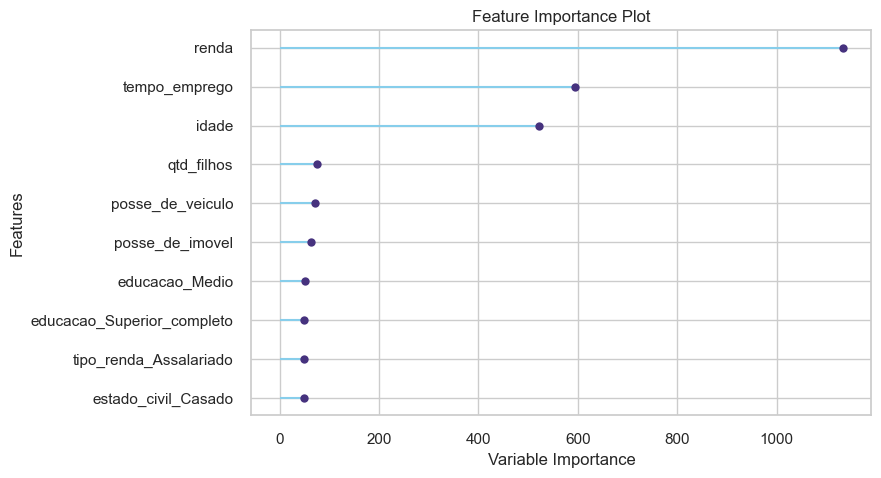

In [65]:
modelo_lightgbm = create_model('lightgbm')

plot_model(modelo_lightgbm, plot='feature')

### Variáveis

Treinei o modelo com ```lightgbm``` e depois construi um gráfico *feature* para analisar as variáveis de acordo com a sua importância.

Neste gráfico, ficou evidente que **renda**, **tempo_emprego** e **idade** são as três variáveis com maior relevância.

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [66]:
s = setup(
    data=df_modelagem,
    target='mau',
    normalize=True,      
    pca=True,            
    pca_method='linear', # 'linear' é o PCA clássico
    pca_components=0.95  # mantém 95% da variância explicada
)

,Description,Value
0,Session id,7994
1,Target,mau
2,Target type,Binary
3,Original data shape,"(142500, 13)"
4,Transformed data shape,"(142500, 22)"
5,Transformed train set shape,"(99750, 22)"
6,Transformed test set shape,"(42750, 22)"
7,Numeric features,5
8,Categorical features,7
9,Preprocess,True


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [67]:
df_dummie = pd.get_dummies(df_modelagem)
df_dummie = df_dummie.astype(int)

df_dummie.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_F,sexo_M,posse_de_veiculo_N,posse_de_veiculo_S,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_Uniao,estado_civil_Viuvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com_os_pais,tipo_residencia_Comunitario,tipo_residencia_Estudio,tipo_residencia_Governamental
0,1,42,2,3,1190,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,63,6,2,3134,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,36,13,1,3045,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
3,0,28,6,2,3149,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,1,34,4,3,2301,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0


In [68]:
s = setup(
    data=df_modelagem,
    target='mau',
    numeric_imputation='mean',      # preenche nulos numéricos com média
    categorical_imputation='mode',  # preenche nulos categóricos com moda
    normalize=True,                 # normaliza dados numéricos
    normalize_method='zscore',
    remove_outliers=True,           # remove outliers
    outliers_method='iforest',
    feature_selection=True,         # ativa seleção de variáveis
    feature_selection_method='sequential',
    feature_selection_estimator='lightgbm',
    session_id=9221
)

,Description,Value
0,Session id,9221
1,Target,mau
2,Target type,Binary
3,Original data shape,"(142500, 13)"
4,Transformed data shape,"(137513, 3)"
5,Transformed train set shape,"(94763, 3)"
6,Transformed test set shape,"(42750, 3)"
7,Numeric features,5
8,Categorical features,7
9,Preprocess,True


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [69]:
X = df_dummie.drop(columns=['mau'])
y = df_dummie['mau']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=10)

# Substituição dos valores nulos
def valores_nulos(df):
    df_filled = df.copy()
    for col in df_filled.columns:
        if df_filled[col].dtype in ['float64', 'int64']:
            df_filled[col].fillna(df_filled[col].median(), inplace=True)
        else:
            df_filled[col].fillna(df_filled[col].mode()[0], inplace=True)
    return df_filled

# Remoção de outliers
def remove_outliers(df, numeric_only=True, threshold=1.5):
    df_clean = df.copy()
    
    # Seleciona colunas numéricas
    if numeric_only:
        cols = df_clean.select_dtypes(include=['number']).columns
    else:
        cols = df_clean.columns
    
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        mask = ~((df_clean[col] < (Q1 - threshold * IQR)) | 
                 (df_clean[col] > (Q3 + threshold * IQR)))
        df_clean = df_clean[mask]
    
    return df_clean

# Define a PCA to Linear dimensionality reduction
pca = PCA(n_components=5)

# Define a Standard Scaler to normalize inputs
scaler_pipe = StandardScaler()

# Criação de dummy
def criar_dummy(df):
    df_copy = df.copy()
    # Seleciona apenas colunas categóricas (object ou category)
    colunas_cat = df_copy.select_dtypes(include=['object', 'category']).columns
    # Aplica get_dummies em todas as colunas categóricas
    df_copy = pd.get_dummies(df_copy, columns=colunas_cat, drop_first=True, dtype=int)
    return df_copy

In [70]:
pipe = Pipeline(steps=[("valor_nulo", valores_nulos(df_dummie)), 
                       ("remove_outlier", remove_outliers(df_dummie)), 
                       ("PCA(5)", pca),
                       ("Scaler", scaler_pipe),
                       ("Cria_dummy", criar_dummy(df_dummie))])


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [71]:
s = setup(
    data=df_modelagem,          
    target='mau',

    # Tratamento de nulos
    numeric_imputation='median',
    categorical_imputation='mode',

    # Remoção de outliers
    remove_outliers=True,
    outliers_method='iforest',
    outliers_threshold=0.05,

    # Normalização
    normalize=True,
    normalize_method='zscore',

    # PCA
    pca=True,
    pca_method='linear',
    pca_components=5,

    # Multicolinearidade
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,

    # Balanceamento
    fix_imbalance=True,  # SMOTE automático

    # Reprodutibilidade
    session_id=9221
)

# Visualiza resumo do setup
print(s)


,Description,Value
0,Session id,9221
1,Target,mau
2,Target type,Binary
3,Original data shape,"(142500, 13)"
4,Transformed data shape,"(204544, 6)"
5,Transformed train set shape,"(161794, 6)"
6,Transformed test set shape,"(42750, 6)"
7,Numeric features,5
8,Categorical features,7
9,Preprocess,True


## Análise

| Etapa                                       | Ação                                                                           |
| ------------------------------------------- | ------------------------------------------------------------------------------ |
|  **Imputação**                            | Preencheu valores nulos com mediana (numéricos) e moda (categóricos).          |
|  **Normalização**                         | Padronizou os dados com *z-score* (média = 0, desvio padrão = 1).              |
|  **Remoção de outliers**                  | Usou método `iforest` (Isolation Forest) para excluir 5% dos valores extremos. |
|  **Remoção de multicolinearidade**        | Eliminou variáveis altamente correlacionadas (r > 0.95).                       |
|  **Balanceamento da variável alvo**       | Aplicou **SMOTE** para equilibrar as classes do target “mau”.                  |
|  **PCA (redução de dimensionalidade)**    | Gerou 10 componentes principais lineares.                                      |
|  **Validação cruzada (cross-validation)** | Utiliza StratifiedKFold com 10 divisões, garantindo equilíbrio nas amostras.   |


In [72]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [73]:
modelo_lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7419,0.4924,0.1356,0.1310,0.1333,-0.0183,-0.0183
1,0.7595,0.5103,0.1486,0.1580,0.1532,0.0132,0.0132
2,0.7539,0.4892,0.1281,0.1366,0.1322,-0.0110,-0.0110
3,0.7496,0.5043,0.1424,0.1432,0.1428,-0.0039,-0.0039
4,0.7588,0.5039,0.1232,0.1379,0.1302,-0.0093,-0.0094
5,0.7616,0.4950,0.1205,0.1387,0.1289,-0.0084,-0.0084
6,0.7603,0.4989,0.1403,0.1530,0.1464,0.0073,0.0073
7,0.7606,0.4894,0.1116,0.1301,0.1201,-0.0175,-0.0176
8,0.7617,0.4939,0.1218,0.1399,0.1303,-0.0070,-0.0071


In [74]:
params_grid = {
  'n_estimators': [2000], # Aumente o número de árvores
  'learning_rate': [0.01, 0.025], # Diminua a taxa de aprendizado
  'num_leaves': [20, 31, 40],
  'min_child_samples': [30, 50, 70],
}

modelo_tunado = tune_model(
    modelo_lightgbm,
    search_library='scikit-optimize', # Fornece métodos de otimização bayesiana
    search_algorithm='bayesian',
    custom_grid = params_grid 
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7818,0.5011,0.0863,0.1300,0.1037,-0.0148,-0.0152
1,0.7908,0.5136,0.1014,0.1603,0.1242,0.0122,0.0126
2,0.7952,0.4912,0.0911,0.1567,0.1152,0.0085,0.0089
3,0.7827,0.5012,0.1054,0.1517,0.1244,0.0049,0.0050
4,0.7913,0.4982,0.0958,0.1554,0.1185,0.0077,0.0079
5,0.7888,0.5054,0.0945,0.1497,0.1158,0.0028,0.0029
6,0.7934,0.4944,0.0849,0.1462,0.1074,-0.0002,-0.0002
7,0.7888,0.4948,0.0787,0.1313,0.0984,-0.0128,-0.0133
8,0.7909,0.4893,0.0856,0.1429,0.1070,-0.0030,-0.0032


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [75]:
print(modelo_tunado.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.025, 'max_depth': -1, 'min_child_samples': 30, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 2000, 'n_jobs': -1, 'num_leaves': 40, 'objective': None, 'random_state': 9221, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [76]:
evaluate_model(modelo_tunado)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [77]:
pipe = Pipeline(steps=[("valor_nulo", valores_nulos(df_dummie)), 
                       ("remove_outlier", remove_outliers(df_dummie)), 
                       ("PCA(5)", pca),
                       ("Scaler", scaler_pipe),
                       ("Cria_dummy", criar_dummy(df_dummie))])

In [78]:
save_model(pipe,'Lightgbm Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('valor_nulo',
                          qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia  renda  mau  \
 0                1     42              2                      3   1190    0   
 1                0     63              6                      2   3134    0   
 2                0     36             13                      1   3045    0   
 3                0     28              6                      2   3149    1   
 4                1     34              4                      3   2301    0   
 ...            ...    ...            ...                    ...    ...  ...   
 142495           0     29              5                      2   1483    0   
 142496           0     53              4                      2   1051    1   
 142497           1     37              3                      3   1476    1   
 142498           1     44             11                      3   9829    0   
 142499           2     58             27       